# Credit Card Fraud

The objective here is to use various classification models specifically for imbalanced data to see how accurate they are in detecting whether a transaction is a normal payment or a fraud. 

In the dataset the features are scaled and the names of the features are not shown due to privacy reasons. 
Nevertheless, we can still analyze some of it's important aspects.

As you go through the models below you will see:
- (1) Basic Classification Models as well as Ensemble Models
- (2) Cost Sensitive Models
- (3) Models with Data Sampling (Under and Over sampling)
- (4) Probabilty Calibrated Models
- (5) Stacked / Voting Models

## Chosen Metric - F2 Score

The metric chosen this particular task is F2Score: 

To achieve an optimal result we would like to maximize two components: 
- The "True Positive Rate" aka Sensitivity aka Recall. Given by: TP/(TP+FN) 
- The Precision - How many of the positive predictions, are in fact correct. Given by: TP/(TP+FP) 

To obtain a balance between both we use F2 Measure which is given by: (2*Precision*Recall)/(Precision+Recall)

## Model with the best result: StochasticGradientDescent Classifier with DataSampling

- Best parameters: SGDClassifier(alpha = 0.02, eta0 = 0.05, fit_intercept = True, l1_ratio = 0.43, loss = 'hinge', penalty = 'elasticnet', random_state=42)

- With regular SMOTE
- With undersampling
                                       

- Best Mean cross-validation score: 0.86

- Test Performance:  0.8171206225680935
- Val Performance:  0.8669354838709679
- Yeilded a Performance of 90.27 on the final Test Data in Kaggle Leaderboard 

# Importing Libraries and Data

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from catboost import CatBoostClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from feature_engine import missing_data_imputers as mdi
from sklearn.model_selection import RepeatedStratifiedKFold
from feature_engine.discretisers import DecisionTreeDiscretiser
from feature_engine.discretisers import EqualFrequencyDiscretiser
from feature_engine.missing_data_imputers import RandomSampleImputer
from feature_engine.variable_transformers import YeoJohnsonTransformer

In [2]:
data =  pd.read_csv("D:\\EverythingDS\\DataSets\\kaggle_imbalanced\\train.csv")
test= pd.read_csv("D:\\EverythingDS\\DataSets\\kaggle_imbalanced\\test.csv")

# Creating custom scorer (F2Score)

In [3]:
#creating a scorer for F2 score so that we can given an emphases on the minority class predictions
from sklearn.metrics import fbeta_score, make_scorer
f2score = make_scorer(fbeta_score, beta=2)
f2score

make_scorer(fbeta_score, beta=2)

# Exploring the Data

In [55]:
data.head()

,Id,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,V29,Target
0,138662,-0.711273,1.272483,1.681631,0.039897,-0.312381,-1.161083,0.853875,-0.173979,-0.438558,...,-0.208181,-0.414631,0.057957,0.930321,-0.165598,0.038799,0.384295,0.192762,21.87,0
1,235999,1.990679,-0.128465,-1.700556,0.529839,0.136889,-1.404270,0.593353,-0.456700,0.648260,...,0.018179,0.179084,-0.004248,0.039531,0.333765,-0.225201,-0.047285,-0.059682,49.99,0
2,245376,1.812653,-0.476162,-0.338988,1.386750,-0.745965,-0.449870,-0.492226,0.029904,1.129394,...,0.252668,0.655719,0.090057,-0.136884,-0.172452,-0.556921,0.036490,-0.021575,79.00,0
3,202483,-1.014219,0.522775,-0.337978,-1.957797,3.578395,3.266965,0.602857,0.644645,-0.305879,...,0.147742,0.590740,-0.680551,0.745346,1.119496,0.013520,0.004530,-0.132643,6.00,0
4,9710,-0.967270,-0.053815,2.273463,-0.894434,0.728924,0.153524,-0.038330,0.165252,1.172526,...,0.106692,0.514430,-0.081546,-0.305042,-0.354883,0.896254,-0.182293,-0.142810,15.95,0


In [56]:
data["Target"].value_counts()

0    24602
1      244
Name: Target, dtype: int64

In [57]:
x = data["Target"].value_counts()
x/x.sum()

0    0.99018
1    0.00982
Name: Target, dtype: float64

## Missing Data

In [6]:
# cumulative missing values
data.isnull().sum()

Id           0
V1        2387
V2           0
V3           0
V4           0
V5           0
V6           0
V7           0
V8           0
V9           0
V10          0
V11          0
V12          0
V13          0
V14          0
V15          0
V16          0
V17          0
V18          0
V19          0
V20       2529
V21          0
V22          0
V23          0
V24          0
V25          0
V26          0
V27          0
V28          0
V29          0
Target       0
dtype: int64

In [58]:
# numerical: discrete vs continuous
discrete = [var for var in data.columns if data[var].dtype!='O' and var!='Target' and data[var].nunique()<10]
continuous = [var for var in data.columns if data[var].dtype!='O' and var!='Target' and var not in discrete]

print(f'There are {len(discrete)} discrete variables')
print(f'There are {len(continuous)} continuous variables')

There are 0 discrete variables
There are 30 continuous variables


In [59]:
# we are dealing with only continuous variables
data[continuous].nunique()

Id     24846
V1     22312
V2     24674
V3     24674
V4     24674
V5     24674
V6     24674
V7     24674
V8     24674
V9     24674
V10    24674
V11    24674
V12    24674
V13    24674
V14    24674
V15    24674
V16    24674
V17    24674
V18    24674
V19    24673
V20    22172
V21    24673
V22    24674
V23    24674
V24    24672
V25    24674
V26    24674
V27    24674
V28    24672
V29     8115
dtype: int64

In [60]:
#percentage of missing values
(data.isna().sum().sum()/(len(data.axes[0])*len(data.axes[1])))*100

0.6382542266815194

## Checking the distribution of data

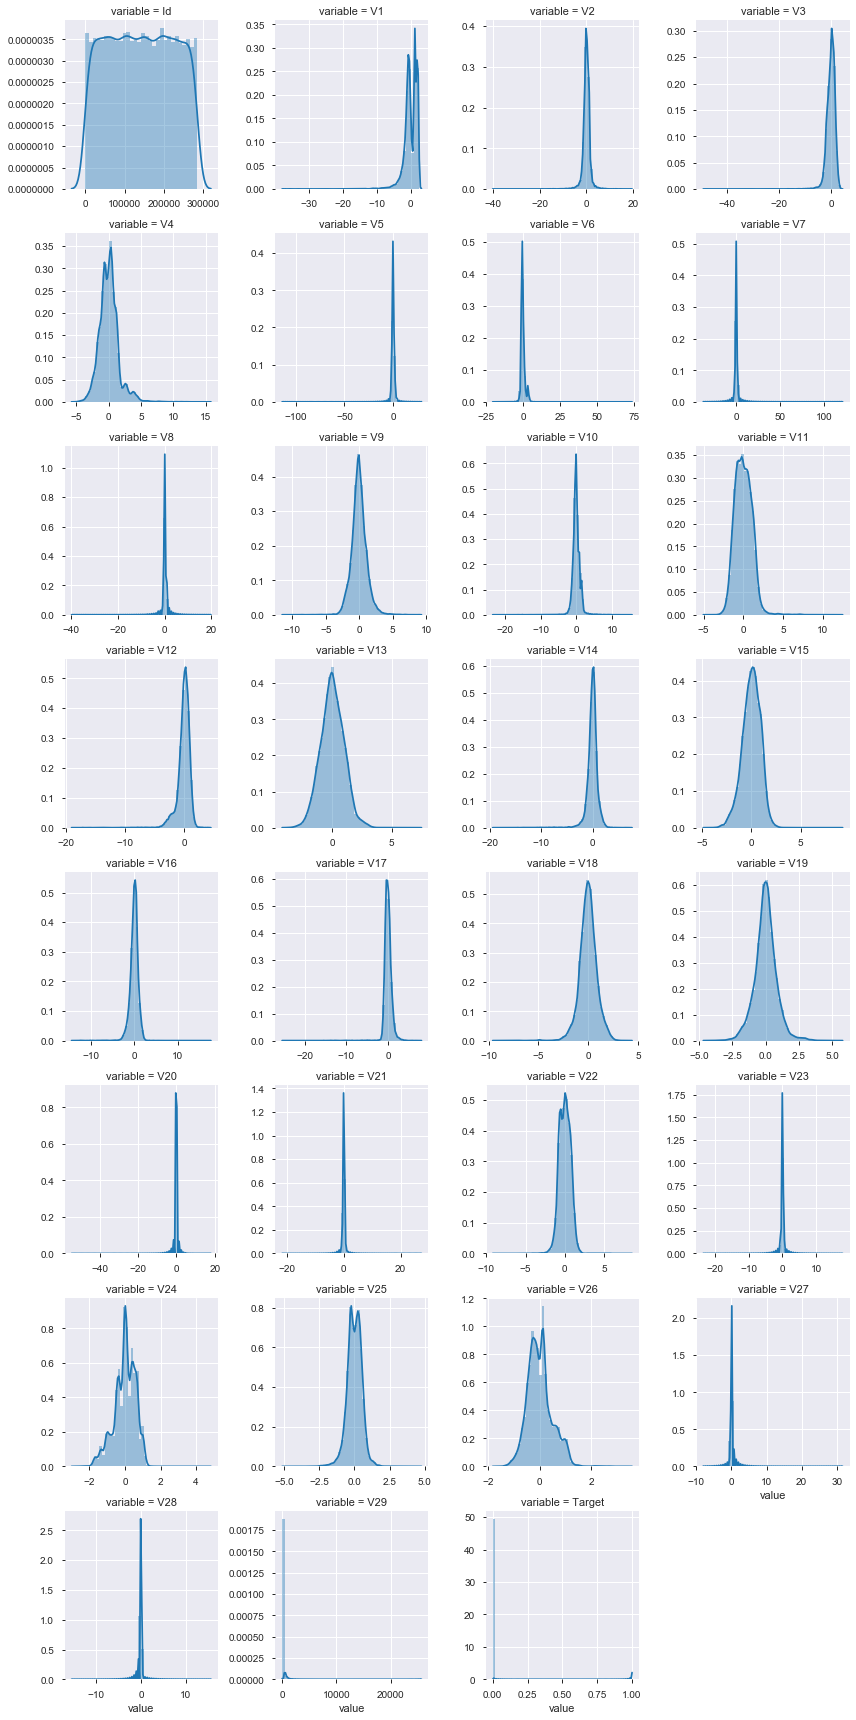

In [22]:
# Checking skewness of other variables via numeric plots
nd = pd.melt(data, value_vars = data.columns)
n1 = sns.FacetGrid (nd, col='variable', col_wrap=4, sharex=False, sharey = False)
n1 = n1.map(sns.distplot, 'value')
n1

## Check skewness of data

In [27]:
data.skew(axis = 0, skipna = True).sort_values(ascending=False)

V29       31.082226
V7        14.244536
V27       11.527237
Target     9.942320
V6         6.670720
V21        4.292609
V11        1.136271
V4         1.001752
V28        0.870101
V26        0.592076
V9         0.260337
V19        0.171951
V13        0.049562
Id         0.006134
V22       -0.238638
V15       -0.309727
V25       -0.417321
V24       -0.547550
V18       -1.008396
V10       -1.434850
V16       -2.660417
V2        -3.556474
V1        -3.656579
V3        -4.334872
V12       -4.429867
V14       -4.435430
V23       -6.185332
V17       -7.868949
V8        -8.230637
V20      -12.780841
V5       -15.003516
dtype: float64

## Outlier Detection

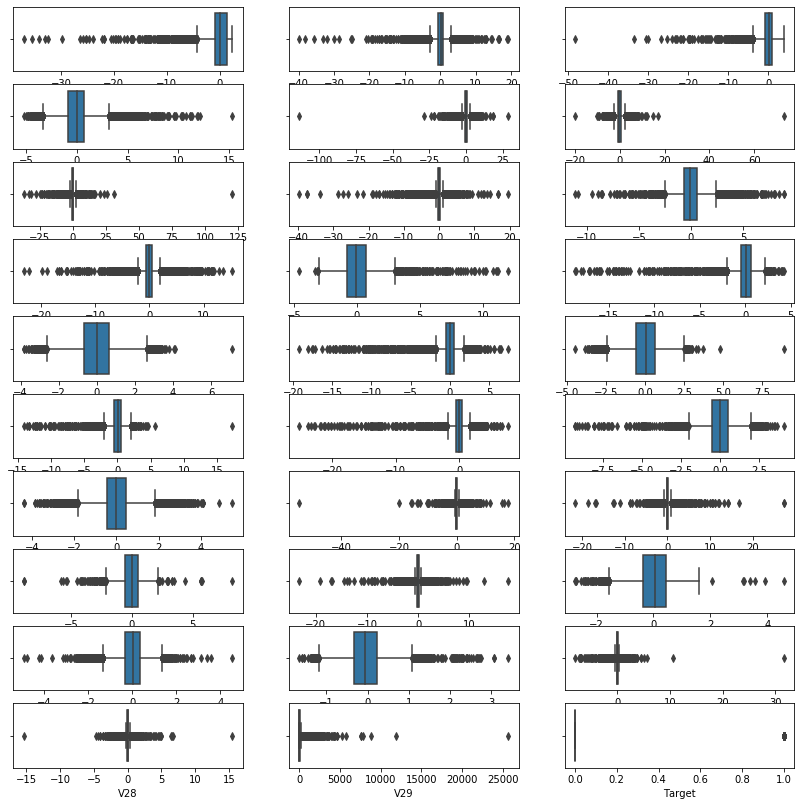

In [51]:
fig, axs = plt.subplots(ncols=3, nrows=10,figsize=(14,14))
axs = axs.flatten()

for i, var in enumerate(continuous + ['Target']):
    sns.boxplot(data[data[var].notnull()][var], ax=axs[i], orient='h');

## Correlation Matrix

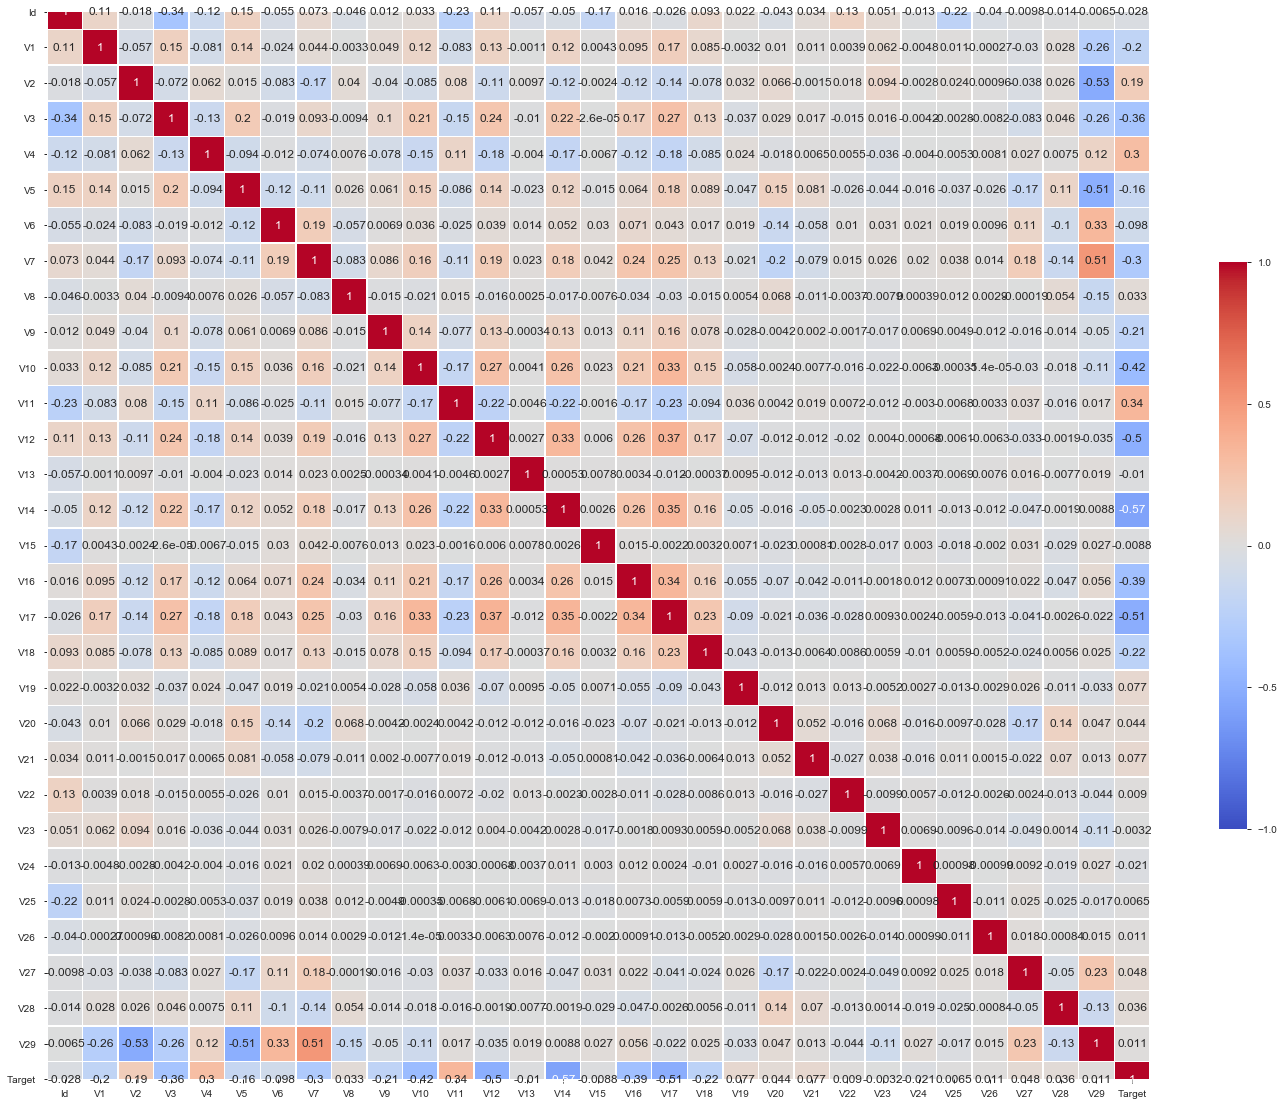

In [29]:
mask = np.zeros_like(data.corr(), dtype=np.bool)
f, ax = plt.subplots(figsize=(20,20)) 
heatmap = sns.heatmap(data.corr(), 
                      mask = mask,
                      square = True,
                      linewidths = .5,
                      cmap = 'coolwarm',
                      cbar_kws = {'shrink': .4, 
                                'ticks' : [-1, -.5, 0, 0.5, 1]},
                      vmin = -1, 
                      vmax = 1,
                      annot = True,
                      annot_kws = {"size": 12})
#add the column names as labels
ax.set_yticklabels(data.corr().columns, rotation = 0)
ax.set_xticklabels(data.corr().columns)
sns.set_style({'xtick.bottom': True}, {'ytick.left': True})
plt.tight_layout()

## Predictive Power Matrix

In [32]:
# Predictive power matrix is helpful in trying to identify 'non-linear' relationships in the data
# https://github.com/8080labs/ppscore

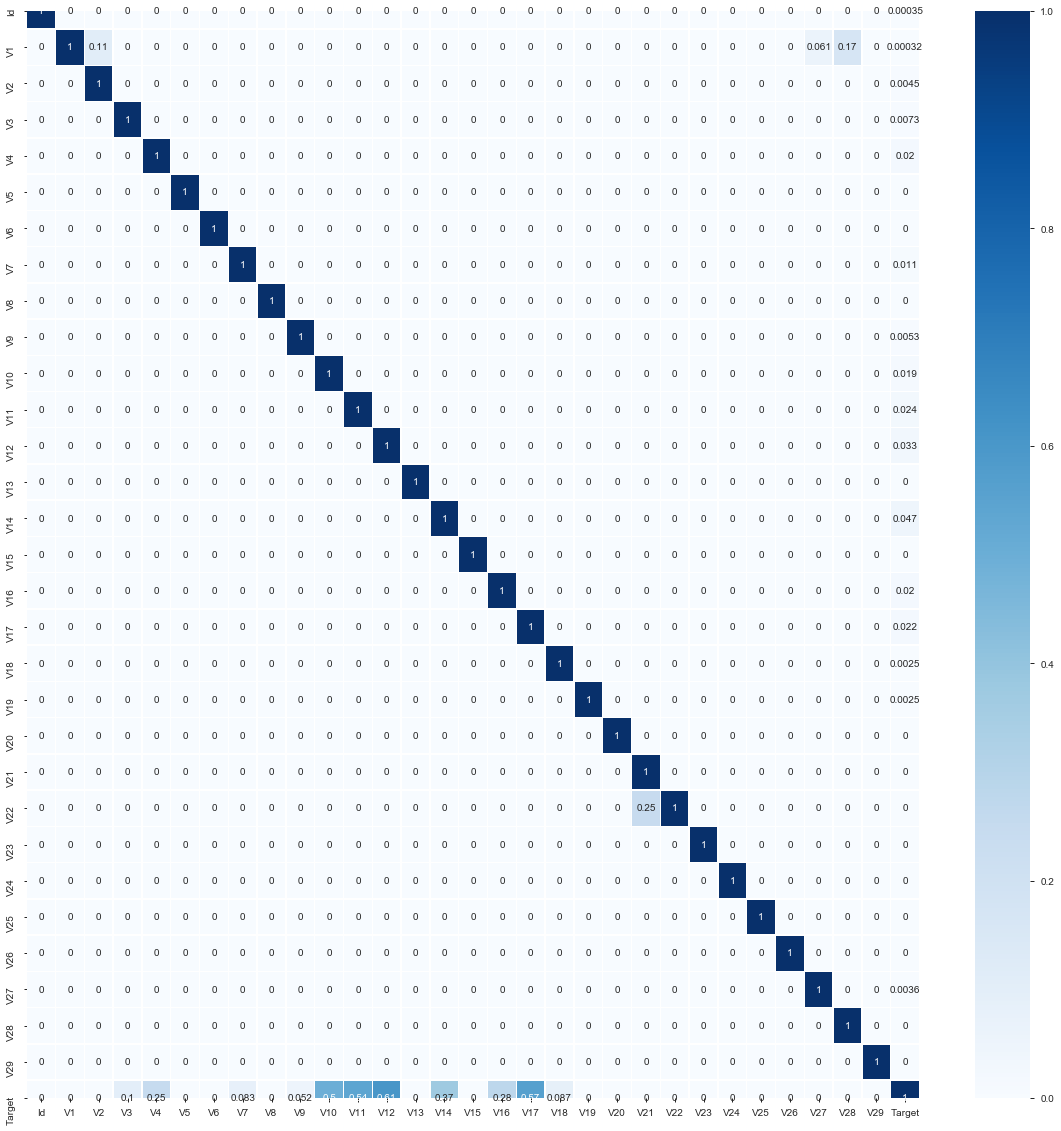

In [33]:
import ppscore as pps
pps.matrix(data)
df_matrix = pps.matrix(data)
fig = plt.figure(figsize=(20,20)) 
sns.heatmap(df_matrix, vmin=0, vmax=1, cmap="Blues", linewidths=0.5, annot=True)

In [34]:
# individually the predictive power of each of the variables seem quite low, I would expect better results with a balanced set

## Splitting data

In [61]:
data = data.drop(["Id"],axis=1)
test = test.drop(["Id"],axis=1)

In [62]:
continuous.remove("Id")

In [63]:
from sklearn.model_selection import train_test_split
X_trainval, X_test, y_trainval, y_test = train_test_split(data.drop('Target',axis=1), data.Target , test_size=0.2, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.25, random_state=0)

# Data Preprocessing

In [64]:
prep_pipe = Pipeline([
    # Imputers
    # Using RandomSampleImpute rather than MeanMedian since the percentage of missing valus are just 0.6 
    ('rand_imputer', RandomSampleImputer(random_state = 40,
                                         seed = 'general',
                                         variables = ['V1','V20'])),
    # Transformer
    # Using YJT since we have negative values in out dataframe
    ('yjt', YeoJohnsonTransformer(variables = continuous)),
    
    # Discretiser
    # Attained best results with DT rather than Equal Frequency or Equal Width
    ('dt_disc', DecisionTreeDiscretiser(cv=10, scoring = f2score,
                                   regression=False,
                                   param_grid={'max_depth': [2,3,4,5]})),
    
    # Scaling
    ("standardscaler" , StandardScaler(with_mean=True, with_std=False)),
    ("robustscaler" , RobustScaler(with_centering=False, with_scaling=True, quantile_range=(0, 100))) 
    ])

In [65]:
prep_pipe.fit(X_train, y_train)
X_train=prep_pipe.transform(X_train)
X_val=prep_pipe.transform(X_val)
X_test=prep_pipe.transform(X_test)

C:\Users\srish\Anaconda3\lib\site-packages\sklearn\utils\validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
C:\Users\srish\Anaconda3\lib\site-packages\sklearn\utils\validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
C:\Users\srish\Anaconda3\lib\site-packages\sklearn\utils\validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
C:\Users\srish\Anaconda3\lib\site-packages\sklearn\utils\validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
C:\U

# Basic Models

## Logistic Regression

In [243]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

logreg = LogisticRegression(max_iter=1000, random_state=42)

logreg_param = {'C': [5.8,5.9], 
                'class_weight' :['balanced', None],
                'penalty': ['l2'], 
                'dual': [False],
                'fit_intercept' : [True],
                'solver':['lbfgs']}

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

logreg_grid = GridSearchCV(logreg, logreg_param, cv=cv, return_train_score=True, scoring= f2score)
logreg_grid.fit(X_train,y_train)

#find best parameters
print('Decision Tree parameters: ', logreg_grid.best_params_)
print()

# Mean Cross validation Score
print("Mean Cross-validation scores: {}".format(logreg_grid.best_score_))
print()

# Check test data set performance
print("Logistic Test Performance: ", logreg_grid.score(X_test,y_test))
print("Logistic Validation Performance: ", logreg_grid.score(X_val,y_val))

Decision Tree parameters:  {'C': 5.9, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'penalty': 'l2', 'solver': 'lbfgs'}

Mean Cross-validation scores: 0.8221070942702128

Logistic Test Performance:  0.6477732793522266
Logistic Validation Performance:  0.7949790794979079


## Decision Tree

In [16]:
from sklearn.tree import DecisionTreeClassifier
dtree = DecisionTreeClassifier(random_state=0)

#define a list of parameters
param_dtree = {"max_depth": [13,15],
               'max_features' : [20,24,27],
               "min_samples_split": [2],
               "max_leaf_nodes": [5,7],
               'min_samples_leaf':[1,2],
               "criterion":['gini'],
               "splitter":['random']}

#apply grid search
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_dtree = GridSearchCV(dtree, param_dtree, cv=cv, return_train_score = True, scoring = f2score)
grid_dtree.fit(X_train, y_train)

# Mean Cross Validation Score
print("Best Mean Cross-validation score: {:.2f}".format(grid_dtree.best_score_))
print()

#find best parameters
print('Decision Tree Best parameters: ',grid_dtree.best_params_)
print()

#Check test data set performance
print("Decision Tree Test Performance: ",grid_dtree.score(X_test,y_test))
print("Decision Tree Val Performance: ",grid_dtree.score(X_val,y_val))
print()

Best Mean Cross-validation score: 0.85

Decision Tree Best parameters:  {'criterion': 'gini', 'max_depth': 13, 'max_features': 24, 'max_leaf_nodes': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'random'}

Decision Tree Test Performance:  0.803921568627451
Decision Tree Val Performance:  0.8401639344262295



## KNN

In [17]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()

# define a list of parameters
param_knn = {'n_neighbors':[16,17,18], 
             'leaf_size':[30],
             'metric':['euclidean'],
             'algorithm':['auto'],
#              'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute'],
             'weights':['distance']}

#apply grid search
knn_grid = GridSearchCV(knn, param_knn, cv=5, return_train_score=True, scoring= f2score)
knn_grid.fit(X_train, y_train)

# Mean Cross Validation Score
print("Best Mean Cross-validation score: {:.2f}".format(knn_grid.best_score_))
print()

#find best parameters
print('KNN Best parameters: ',knn_grid.best_params_)
print()

#Check test data set performance
print("KNN Test Performance: ",knn_grid.score(X_test,y_test))
print("KNN Val Performance: ",knn_grid.score(X_val,y_val))

Best Mean Cross-validation score: 0.81

KNN Best parameters:  {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'euclidean', 'n_neighbors': 16, 'weights': 'distance'}

KNN Test Performance:  0.7199999999999999
KNN Val Performance:  0.7773109243697479


## SGDClassifier

In [231]:
from sklearn.linear_model import SGDClassifier
sgdc = SGDClassifier(random_state=42)
sgdc_param = [{'alpha':[0.0002,0.002,0.02],
               'class_weight':[{0:99,1:1}, 'balanced', None],
               'fit_intercept':[True,False],
               'eta0':[0.05,0.5],
               'l1_ratio': [0.43, 0.97, 0.69],
               'penalty':['elasticnet','l2'],
               'loss':['hinge']}]

sgdc_grid = GridSearchCV(sgdc, sgdc_param, cv=5, return_train_score=True, scoring= f2score)
sgdc_grid.fit(X_train, y_train)

# Mean Cross Validation Score
print("Best Mean Cross-validation score: {:.2f}".format(sgdc_grid.best_score_))
print()

#find best parameters
print('Best parameters: ',sgdc_grid.best_params_)
print()

#Check test data set performance
print("SGDC Test Performance: ",sgdc_grid.score(X_test,y_test))
print("SGDC Val Performance: ",sgdc_grid.score(X_val,y_val))

Best Mean Cross-validation score: 0.87

Best parameters:  {'alpha': 0.02, 'class_weight': 'balanced', 'eta0': 0.05, 'fit_intercept': True, 'l1_ratio': 0.43, 'loss': 'hinge', 'penalty': 'elasticnet'}

SGDC Test Performance:  0.8171206225680935
SGDC Val Performance:  0.8502024291497975


## SVM

In [19]:
from sklearn.svm import LinearSVC
lsvc = LinearSVC(random_state=42)
lsvc_param = [{'penalty':['l2'], 
               'C': [0.001, 0.01, 0.1], 
               'loss':['hinge','squared_hinge']}]

lsvc_grid = GridSearchCV(lsvc, lsvc_param, cv=10, return_train_score=True,scoring= f2score)
lsvc_grid.fit(X_train, y_train)

# Mean Cross Validation Score
print("Best Mean Cross-validation score: {:.2f}".format(lsvc_grid.best_score_))
print()

#find best parameters
print('Best parameters: ',lsvc_grid.best_params_)
print()

#Check test data set performance
print("Linear SVC Test Performance: ",lsvc_grid.score(X_test,y_test))
print("Linear SVC Val Performance: ",lsvc_grid.score(X_val,y_val))
print()

C:\Users\srish\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Best Mean Cross-validation score: 0.83

Best parameters:  {'C': 0.1, 'loss': 'squared_hinge', 'penalty': 'l2'}

Linear SVC Test Performance:  0.753968253968254
Linear SVC Val Performance:  0.8091286307053941



## Kernel SVM

In [235]:
from sklearn.svm import SVC
svc = SVC(random_state=42)

param_grid = [{'C': [0.1,0.6,6,8.5],
               'class_weight':[{0:99,1:1},{0:10,1:1}, 'balanced', None],
               'kernel':['rbf','poly'],
               'degree':[2,3]}]

svm_grid = GridSearchCV(svc, param_grid, cv=5,return_train_score=True,scoring=f2score)
svm_grid.fit(X_train, y_train)

# Mean Cross Validation Score
print("Best Mean Cross-validation score: {:.2f}".format(svm_grid.best_score_))
print()

#find best parameters
print('Support Vector Classifier Best parameters: ',svm_grid.best_params_)
print()

#Check test data set performance
print("Support Vector Classifier Test Performance: ",svm_grid.score(X_test,y_test))
print("Support Vector Classifier Val Performance: ",svm_grid.score(X_val,y_val))
print()

Best Mean Cross-validation score: 0.86

Support Vector Classifier Best parameters:  {'C': 6, 'class_weight': {0: 99, 1: 1}, 'degree': 2, 'kernel': 'rbf'}

Support Vector Classifier Test Performance:  0.7374100719424461
Support Vector Classifier Val Performance:  0.7509157509157509



## Naive Bayes

In [21]:
from sklearn.naive_bayes import GaussianNB
naive = GaussianNB()

param_grid = [{'priors':[None],
               'var_smoothing':[0.004,0.01,0.000000001]}]
naive_grid = GridSearchCV(naive, param_grid, cv=5, return_train_score=True,scoring=f2score)
naive_grid.fit(X_train,y_train)

# Mean Cross Validation Score
print("Best Mean Cross-validation score: {:.2f}".format(naive_grid.best_score_))
print()

#find best parameters
print('Support Vector Classifier Best parameters: ',naive_grid.best_params_)
print()

#Check test data set performance
print("NB Test Performance: ",naive_grid.score(X_test,y_test))
print("NB Classifier Val Performance: ",naive_grid.score(X_val,y_val))

Best Mean Cross-validation score: 0.73

Support Vector Classifier Best parameters:  {'priors': None, 'var_smoothing': 0.01}

NB Test Performance:  0.6615384615384615
NB Classifier Val Performance:  0.649546827794562


## QDA

In [80]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
param_grid = {
    'reg_param': np.arange(0,1,0.01),
    'priors': [None],
    'reg_param': [0,0.2,0.1],
    'tol': [0.0001, 0.001]
    
                     }    

qda_grid = GridSearchCV(QuadraticDiscriminantAnalysis(), 
                          param_grid, scoring=f2score,
                         cv=5,  n_jobs=-1)

qda_grid.fit(X_train,y_train)
# Mean Cross Validation Score
print("Best Mean Cross-validation score: {:.2f}".format(qda_grid.best_score_))
print()

#find best parameters
print('Best parameters: ',qda_grid.best_params_)
print()

#Check test data set performance
print("Test Performance: ",qda_grid.score(X_test,y_test))
print("Val Performance: ",qda_grid.score(X_val,y_val))

Best Mean Cross-validation score: 0.72

Best parameters:  {'priors': None, 'reg_param': 0.1, 'tol': 0.0001}

Test Performance:  0.5967078189300411
Val Performance:  0.723404255319149


## LDA

In [81]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

param_grid = {'solver' : ['lsqr', 'eigen'],
              'shrinkage': [None, 0.0001, 0.001, 0.01, 0.0005, 0.005, 0.05, 0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
                     }    

lda_grid = GridSearchCV(LinearDiscriminantAnalysis(), 
                                param_grid, scoring=f2score,
                                cv=10,n_jobs=-1)

lda_grid.fit(X_train,y_train)
# Mean Cross Validation Score
print("Best Mean Cross-validation score: {:.2f}".format(lda_grid.best_score_))
print()

#find best parameters
print('Best parameters: ',lda_grid.best_params_)
print()

#Check test data set performance
print("Test Performance: ",lda_grid.score(X_test,y_test))
print("Val Performance: ",lda_grid.score(X_val,y_val))

Best Mean Cross-validation score: 0.86

Best parameters:  {'shrinkage': None, 'solver': 'lsqr'}

Test Performance:  0.803921568627451
Val Performance:  0.816326530612245


# Ensemble Models

## Bagging with DTree

In [22]:
from sklearn.ensemble import BaggingClassifier
bag_dtree1 = BaggingClassifier(base_estimator=DecisionTreeClassifier(), bootstrap=True, random_state=0, oob_score=False)

bag_dtree1_param = {
                 'base_estimator__max_depth': [3,13,19],
                 'base_estimator__max_features': [11,13,24],
                 'base_estimator__min_samples_leaf': [2,5],
                 'max_samples':  [0.8,1],
                 'n_estimators': [10,100]}

# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
bag_dtree1_grid = GridSearchCV(bag_dtree1, bag_dtree1_param,cv=10, return_train_score=True, scoring= f2score)
bag_dtree1_grid.fit(X_train,y_train)

print(f'Best Params: {bag_dtree1_grid.best_params_}')
print()
print(f'Best Mean Cross Validation Score is {bag_dtree1_grid.best_score_}')
print()
print(f'Test score is {bag_dtree1_grid.score(X_test,y_test)}')
print(f'Val score is {bag_dtree1_grid.score(X_val,y_val)}')

Best Params: {'base_estimator__max_depth': 13, 'base_estimator__max_features': 11, 'base_estimator__min_samples_leaf': 2, 'max_samples': 0.8, 'n_estimators': 10}

Best Mean Cross Validation Score is 0.8676939197501303

Test score is 0.80078125
Train score is 0.823045267489712


## Random Forest

In [23]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=42)
rfc_param = { 
    'n_estimators': [50,90,150,500],
    'bootstrap' : [False],
    'max_features': ['auto','log2'],
    'max_depth' : [3,7,20,110],
    'criterion' :['gini'],#try entropy
    'min_samples_split':[2,10],
    'min_samples_leaf':[1,2],
    'class_weight' : [None] #try balanced
}

# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
rfc_grid2 = GridSearchCV(rf, rfc_param,cv=10, return_train_score=True, scoring = f2score)
rfc_grid2.fit(X_train,y_train)

In [24]:
print(f'Best Params: {rfc_grid2.best_params_}')
print()
print(f'Best Mean Cross Validation Score is {rfc_grid2.best_score_}')
print()
print("RFC Test Performance: ",rfc_grid2.score(X_test,y_test))
print("RFC Val Performance: ",rfc_grid2.score(X_val,y_val))

Best Params: {'bootstrap': False, 'class_weight': None, 'criterion': 'gini', 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 50}

Best Mean Cross Validation Score is 0.8748687234808374

RFC Test Performance:  0.7945736434108527
RFC Val Performance:  0.836734693877551


## Extra Trees

In [25]:
from sklearn.ensemble import ExtraTreesClassifier
etc = ExtraTreesClassifier(random_state=42)
etc_param = {
    'bootstrap' : [True,False],
    'max_features': ['auto','log2'],
    'max_depth' : [10,50,70],
    'n_estimators' : [90,140,180],
    'criterion' :['gini','entropy'],
    'min_samples_split':[2,5,10],
    'min_samples_leaf':[1,2,4]
}

# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
etc_grid2=GridSearchCV(etc, etc_param, cv=10, return_train_score=True, scoring = f2score)
etc_grid2.fit(X_train,y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0,
                                            class_weight=None, criterion='gini',
                                            max_depth=None, max_features='auto',
                                            max_leaf_nodes=None,
                                            max_samples=None,
                                            min_impurity_decrease=0.0,
                                            min_impurity_split=None,
                                            min_samples_leaf=1,
                                            min_samples_split=2,
                                            min_weight_fraction_leaf=0.0,
                                            n_estimators=100, n_jobs=None,...
                                            verbose=0, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'bootstrap': [True, False],
      

In [27]:
print(f'Best Params: {etc_grid2.best_params_}')
print()
print(f'Best Mean Cross Validation Score is {etc_grid2.best_score_}')
print()
print("ETC Test Performance: ",etc_grid2.score(X_test,y_test))
print("ETC Val Performance: ",etc_grid2.score(X_val,y_val))

Best Params: {'bootstrap': False, 'criterion': 'gini', 'max_depth': 50, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 140}

Best Mean Cross Validation Score is 0.8748687234808374

ETC Test Performance:  0.803921568627451
ETC Val Performance:  0.8264462809917357


## Gradient Boosting

In [29]:
from  sklearn.ensemble import GradientBoostingClassifier
gbc= GradientBoostingClassifier(random_state=42)
gbc_param = {
              'min_samples_split':[2,3],
              'subsample':[0.6,0.8,1],
              'min_samples_leaf':[1,2],
              'max_depth' : [2,3,7],
              'max_features':['auto'],
              'n_estimators' : [100,150],
              'learning_rate' : [0.5,1.0,2]
             }

# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
gbc_grid = GridSearchCV(gbc, gbc_param, cv=5, return_train_score=True, scoring = f2score)
gbc_grid.fit(X_train,y_train)
print()

In [30]:
print(f'Best Params: {gbc_grid.best_params_}')
print()
print(f'Best Mean Cross Validation Score is {gbc_grid.best_score_}')
print()
print(f'Test score is {gbc_grid.score(X_test,y_test)}')
print(f'Train score is {gbc_grid.score(X_val,y_val)}')

Best Params: {'learning_rate': 1.0, 'max_depth': 2, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'subsample': 1}

Best Mean Cross Validation Score is 0.8575435853051795

Test score is 0.7587548638132298
Train score is 0.8299595141700403


## XGBoost

In [34]:
from xgboost import XGBClassifier
xgbc= XGBClassifier(random_state=42, n_jobs=-1, objective = 'binary:logistic')
xgbc_param = {
              'max_depth' : [6],
              'n_estimators' : [800],
              'learning_rate' : [0.4],
              'gamma' : [0,1],
              'min_child_weight' : [1,3],
              'subsample':[0.7],
              'colsample_bytree':[1],
              'lambda':[0],
              'alpha':[0.5]
             }

# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
xgbc_grid = GridSearchCV(xgbc, xgbc_param, cv=5, return_train_score=True, scoring = f2score)
xgbc_grid.fit(X_train,y_train)
print()

In [35]:
print(f'Best Params: {xgbc_grid.best_params_}')
print()
print(f'Best Mean Cross Validation Score is {xgbc_grid.best_score_}')
print()
print(f'Test score is {xgbc_grid.score(X_test,y_test)}')
print(f'Train score is {xgbc_grid.score(X_val,y_val)}')

Best Params: {'alpha': 0, 'colsample_bytree': 0.6, 'gamma': 1, 'lambda': 0, 'learning_rate': 0.5, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 800, 'subsample': 1}

Best Mean Cross Validation Score is 0.8754126747763868

Test score is 0.7843137254901962
Train score is 0.836734693877551


## CatBoost

In [78]:
from catboost import CatBoostClassifier
cat = CatBoostClassifier()

param_grid = {
            'depth':[10,20],
            'iterations':[250,100,500,1000], 
            'learning_rate':[0.03,0.001,0.01,0.1,0.2,0.3], 
            'l2_leaf_reg':[3,1,5,10,100], 
            'border_count':[32,5,10,20,50,100,200], 
            'loss_function' :['Logloss'],
            'border_count':[10],
            'scale_pos_weight' : [9]
                      }

cat_grid = GridSearchCV(cat, param_grid, cv = 5, n_jobs=-1, scoring = f2score)
cat_grid.fit(X_train, y_train) 
print(f'Best Params: {cat_grid.best_params_}')
print()
print(f'Best Mean Cross Validation Score is {cat_grid.best_score_}')
print()
print(f'Test score is {cat_grid.score(X_test,y_test)}')
print(f'Train score is {cat_grid.score(X_val,y_val)}')

0:	learn: 0.5574995	total: 522ms	remaining: 6m 56s
1:	learn: 0.4531834	total: 602ms	remaining: 4m
2:	learn: 0.3727178	total: 673ms	remaining: 2m 58s
3:	learn: 0.3089029	total: 747ms	remaining: 2m 28s
4:	learn: 0.2634720	total: 790ms	remaining: 2m 5s
5:	learn: 0.2253475	total: 801ms	remaining: 1m 46s
6:	learn: 0.1930813	total: 814ms	remaining: 1m 32s
7:	learn: 0.1655954	total: 913ms	remaining: 1m 30s
8:	learn: 0.1473625	total: 951ms	remaining: 1m 23s
9:	learn: 0.1322951	total: 961ms	remaining: 1m 15s
10:	learn: 0.1194533	total: 973ms	remaining: 1m 9s
11:	learn: 0.1099735	total: 1000ms	remaining: 1m 5s
12:	learn: 0.1023128	total: 1.05s	remaining: 1m 3s
13:	learn: 0.0940983	total: 1.1s	remaining: 1m 1s
14:	learn: 0.0885243	total: 1.46s	remaining: 1m 16s
15:	learn: 0.0830402	total: 1.49s	remaining: 1m 13s
16:	learn: 0.0789453	total: 1.52s	remaining: 1m 10s
17:	learn: 0.0758065	total: 1.53s	remaining: 1m 6s
18:	learn: 0.0722812	total: 1.57s	remaining: 1m 4s
19:	learn: 0.0695349	total: 1.6s	

161:	learn: 0.0295694	total: 7.83s	remaining: 30.8s
162:	learn: 0.0295650	total: 7.84s	remaining: 30.7s
163:	learn: 0.0295611	total: 7.88s	remaining: 30.6s
164:	learn: 0.0295573	total: 7.9s	remaining: 30.4s
165:	learn: 0.0295533	total: 7.92s	remaining: 30.3s
166:	learn: 0.0295496	total: 7.93s	remaining: 30.1s
167:	learn: 0.0295460	total: 7.96s	remaining: 29.9s
168:	learn: 0.0295425	total: 8s	remaining: 29.9s
169:	learn: 0.0295387	total: 8.02s	remaining: 29.7s
170:	learn: 0.0295353	total: 8.06s	remaining: 29.6s
171:	learn: 0.0293753	total: 8.11s	remaining: 29.6s
172:	learn: 0.0293720	total: 8.13s	remaining: 29.5s
173:	learn: 0.0293685	total: 8.15s	remaining: 29.3s
174:	learn: 0.0293653	total: 8.17s	remaining: 29.2s
175:	learn: 0.0291402	total: 8.21s	remaining: 29.1s
176:	learn: 0.0291370	total: 8.22s	remaining: 29s
177:	learn: 0.0291339	total: 8.24s	remaining: 28.8s
178:	learn: 0.0291307	total: 8.32s	remaining: 28.9s
179:	learn: 0.0291274	total: 8.36s	remaining: 28.8s
180:	learn: 0.0291

320:	learn: 0.0223879	total: 14s	remaining: 20.9s
321:	learn: 0.0223404	total: 14s	remaining: 20.8s
322:	learn: 0.0222587	total: 14.1s	remaining: 20.8s
323:	learn: 0.0221797	total: 14.1s	remaining: 20.8s
324:	learn: 0.0221034	total: 14.2s	remaining: 20.7s
325:	learn: 0.0220295	total: 14.2s	remaining: 20.7s
326:	learn: 0.0219580	total: 14.3s	remaining: 20.6s
327:	learn: 0.0218742	total: 14.3s	remaining: 20.6s
328:	learn: 0.0218058	total: 14.4s	remaining: 20.6s
329:	learn: 0.0217396	total: 14.4s	remaining: 20.5s
330:	learn: 0.0216754	total: 14.5s	remaining: 20.5s
331:	learn: 0.0215967	total: 14.5s	remaining: 20.4s
332:	learn: 0.0215351	total: 14.5s	remaining: 20.4s
333:	learn: 0.0214754	total: 14.6s	remaining: 20.4s
334:	learn: 0.0214005	total: 14.6s	remaining: 20.3s
335:	learn: 0.0213431	total: 14.7s	remaining: 20.3s
336:	learn: 0.0212874	total: 14.7s	remaining: 20.2s
337:	learn: 0.0212159	total: 14.8s	remaining: 20.2s
338:	learn: 0.0211623	total: 14.8s	remaining: 20.1s
339:	learn: 0.02

480:	learn: 0.0168695	total: 21.3s	remaining: 14.1s
481:	learn: 0.0168333	total: 21.4s	remaining: 14.1s
482:	learn: 0.0168224	total: 21.4s	remaining: 14.1s
483:	learn: 0.0167866	total: 21.5s	remaining: 14s
484:	learn: 0.0167522	total: 21.5s	remaining: 14s
485:	learn: 0.0167428	total: 21.6s	remaining: 14s
486:	learn: 0.0167140	total: 21.6s	remaining: 13.9s
487:	learn: 0.0167032	total: 21.7s	remaining: 13.9s
488:	learn: 0.0166751	total: 21.7s	remaining: 13.8s
489:	learn: 0.0166476	total: 21.8s	remaining: 13.8s
490:	learn: 0.0166383	total: 21.8s	remaining: 13.7s
491:	learn: 0.0166114	total: 21.9s	remaining: 13.7s
492:	learn: 0.0166007	total: 21.9s	remaining: 13.6s
493:	learn: 0.0165742	total: 21.9s	remaining: 13.6s
494:	learn: 0.0165335	total: 22s	remaining: 13.5s
495:	learn: 0.0165245	total: 22s	remaining: 13.5s
496:	learn: 0.0165156	total: 22.1s	remaining: 13.4s
497:	learn: 0.0164442	total: 22.1s	remaining: 13.4s
498:	learn: 0.0164159	total: 22.1s	remaining: 13.3s
499:	learn: 0.0164071	

639:	learn: 0.0131062	total: 29.2s	remaining: 7.3s
640:	learn: 0.0130540	total: 29.2s	remaining: 7.25s
641:	learn: 0.0130370	total: 29.3s	remaining: 7.2s
642:	learn: 0.0130323	total: 29.3s	remaining: 7.16s
643:	learn: 0.0129814	total: 29.4s	remaining: 7.12s
644:	learn: 0.0129671	total: 29.4s	remaining: 7.07s
645:	learn: 0.0129563	total: 29.5s	remaining: 7.02s
646:	learn: 0.0129474	total: 29.5s	remaining: 6.97s
647:	learn: 0.0129309	total: 29.5s	remaining: 6.93s
648:	learn: 0.0129240	total: 29.6s	remaining: 6.88s
649:	learn: 0.0129080	total: 29.6s	remaining: 6.83s
650:	learn: 0.0128924	total: 29.7s	remaining: 6.79s
651:	learn: 0.0128856	total: 29.7s	remaining: 6.74s
652:	learn: 0.0128790	total: 29.7s	remaining: 6.69s
653:	learn: 0.0128720	total: 29.8s	remaining: 6.65s
654:	learn: 0.0128621	total: 29.8s	remaining: 6.6s
655:	learn: 0.0128471	total: 29.9s	remaining: 6.55s
656:	learn: 0.0128374	total: 29.9s	remaining: 6.51s
657:	learn: 0.0128228	total: 30s	remaining: 6.47s
658:	learn: 0.012

799:	learn: 0.0106354	total: 36.9s	remaining: 0us
Best Params: {'border_count': 10, 'depth': 10, 'iterations': 800, 'l2_leaf_reg': 120, 'learning_rate': 0.07, 'loss_function': 'Logloss', 'scale_pos_weight': 9}

Best Mean Cross Validation Score is 0.8670532726213642

Test score is 0.8171206225680935
Train score is 0.8536585365853657


## LightGBM

In [79]:
import lightgbm as lgb
gridParams = {
    'learning_rate': [0.2,0.4,0.5],
    'n_estimators': [10,50,90],
    'num_leaves': [40,50,100],
    'colsample_bytree' : [0.65, 1],
    'subsample' : [0.7,1],
    'reg_alpha' : [0.1,0.5,0.6],
    'reg_lambda' : [0.1,0.4],
    'max_depth' : [20,90],
    'min_split_gain' : [0.4,0.5,0.8]
    }

mdl = lgb.LGBMClassifier(boosting_type= 'gbdt',
                         random_state=42,
                         objective = 'binary',
                         silent = True,
                         subsample_for_bin = 200000,
                         subsample_freq = 0,
                         min_child_weight = 0.001,
                         min_child_samples = 20)

lgbm_grid = GridSearchCV(mdl, gridParams, cv=5, n_jobs=-1, return_train_score=True, scoring = f2score)
lgbm_grid.fit(X_train,y_train)
print(f'Best Params: {lgbm_grid.best_params_}')
print()
print(f'Best Mean Cross Validation Score is {lgbm_grid.best_score_}')
print()
print(f'Test score is {lgbm_grid.score(X_test,y_test)}')
print(f'Train score is {lgbm_grid.score(X_val,y_val)}')

Best Params: {'colsample_bytree': 1, 'learning_rate': 0.4, 'max_depth': 10, 'min_split_gain': 0.3, 'n_estimators': 50, 'num_leaves': 30, 'reg_alpha': 0.6, 'reg_lambda': 0.1, 'subsample': 0.7}

Best Mean Cross Validation Score is 0.8671423383374475

Test score is 0.6854838709677419
Train score is 0.823045267489712


# Neural Network

## MLPClassifier

In [152]:
from sklearn.neural_network import MLPClassifier
mlpc = MLPClassifier(hidden_layer_sizes=(5,5,5), max_iter=500, random_state=7)
param = {}

mlp_grid= GridSearchCV(mlpc, param, cv=10, n_jobs=-1, scoring=f2score)
mlp_clf = mlp_grid.fit(X_train,y_train)

print("Best Mean cross-validation score: {:.2f}".format(mlp_clf.best_score_))
print()
print("Test Performance: ",mlp_clf.score(X_test,y_test))
print("Val Performance: ",mlp_clf.score(X_val,y_val))
print()

Best Mean cross-validation score: 0.85

Test Performance:  0.7647058823529411
Val Performance:  0.8333333333333333



# Cost Sensitive Algorithms

## Logistic Regression

In [85]:
#cost sensitive logistic regession
param_grid = {
    'class_weight': [{0:1,1:10}, {0:1,1:20}, {0:1,1:30}, {0:1,1:40}, {0:1,1:15}, ]
}
#apply grid search
logreg_grid_cs= GridSearchCV(LogisticRegression(), 
                             param_grid, cv=5, n_jobs=2, scoring= f2score)
logreg_grid_cs.fit(X_train, y_train)

print("Best parameters: {}".format(logreg_grid_cs.best_params_))
print("Best Mean cross-validation score: {:.2f}".format(logreg_grid_cs.best_score_))

# Check test data set performance
print("CS Logistic Test Performance: ", logreg_grid_cs.score(X_test,y_test))
print("CS Logistic Validation Performance: ", logreg_grid_cs.score(X_val,y_val))

Best parameters: {'class_weight': {0: 1, 1: 15}}
Best Mean cross-validation score: 0.86
CS Logistic Test Performance:  0.7915057915057916
CS Logistic Validation Performance:  0.8108108108108109


## Decision Tree

In [155]:
param_grid = { 
    'class_weight': [{0:1,1:10}, {0:1,1:20}, {0:1,1:30}, {0:1,1:40}, {0:1,1:15}]
}
#apply grid search
grid_dtree_cs= GridSearchCV(DecisionTreeClassifier(criterion = 'gini', max_depth = 13, max_leaf_nodes=5, 
                                                 min_samples_split= 2, min_samples_leaf = 1, max_features =24, 
                                                 splitter='random'), 
                          param_grid, cv=5, n_jobs=2, scoring= f2score)
grid_dtree_cs.fit(X_train, y_train)

print("Best parameters: {}".format(grid_dtree_cs.best_params_))
print("Best Mean cross-validation score: {:.2f}".format(grid_dtree_cs.best_score_))
#Check test data set performance
print("CS DTree Test Performance: ",grid_dtree_cs.score(X_test,y_test))
print("CS DTree Val Performance: ",grid_dtree_cs.score(X_val,y_val))
print()

Best parameters: {'class_weight': {0: 1, 1: 10}}
Best Mean cross-validation score: 0.84
CS DTree Test Performance:  0.7751937984496124
CS DTree Val Performance:  0.8536585365853657



## SDGC

In [95]:
param_grid = { 
    'class_weight': [{0:10,1:80},{0:1,1:90},{0:1,1:95},{0:1,1:70},{0:1,1:60},{0:1,1:100}],
}
#apply grid search
sgdc_grid_cs= GridSearchCV(SGDClassifier(alpha = 0.02, eta0 = 0.05, fit_intercept = True, l1_ratio = 0.43,
                                        loss = 'hinge', penalty = 'elasticnet', random_state=42), 
                          param_grid, cv=5, n_jobs=2, scoring= f2score)
sgdc_grid_cs.fit(X_train, y_train)

print("Best parameters: {}".format(sgdc_grid_cs.best_params_))
print("Best Mean cross-validation score: {:.2f}".format(sgdc_grid_cs.best_score_))
#Check test data set performance
print("CS DTree Test Performance: ",sgdc_grid_cs.score(X_test,y_test))
print("CS DTree Val Performance: ",sgdc_grid_cs.score(X_val,y_val))
print()

Best parameters: {'class_weight': {0: 10, 1: 80}}
Best Mean cross-validation score: 0.87
CS DTree Test Performance:  0.8171206225680935
CS DTree Val Performance:  0.8502024291497975



## Linear SVM

In [95]:
param_grid = { 
    'class_weight': [{0:1,1:10},{0:1,1:20},{0:1,1:15},{0:1,1:18},{0:1,1:12}],
}
lsvc_grid_cs= GridSearchCV(LinearSVC(C =0.3, loss = 'squared_hinge', penalty = 'l2'), 
                        param_grid, cv=5, n_jobs=2, scoring=f2score)
lsvc_grid_cs.fit(X_train, y_train)

print("Best parameters: {}".format(lsvc_grid_cs.best_params_))
print()
print("Best Mean cross-validation score: {:.2f}".format(lsvc_grid_cs.best_score_))
print()
#Check test data set performance
print("LSVC Test Performance: ",lsvc_grid_cs.score(X_test,y_test))
print("LSVC Val Performance: ",lsvc_grid_cs.score(X_val,y_val))
print()

Best parameters: {'class_weight': {0: 1, 1: 15}}

Best Mean cross-validation score: 0.85

LSVC Test Performance:  0.75
LSVC Val Performance:  0.7984790874524715



## Kernel SVM

In [102]:
param_grid = { 
    'class_weight': [{0:1,1:1}, {0:1,1:5},{0:1,1:3},{0:1,1:7},],
}
svm_grid_cs= GridSearchCV(SVC(C= 4, degree = 2, kernel = 'rbf'), 
                        param_grid, cv=5, n_jobs=2, scoring=f2score)
svm_grid_cs.fit(X_train, y_train)

print("Best parameters: {}".format(svm_grid_cs.best_params_))
print()
print("Best Mean cross-validation score: {:.2f}".format(svm_grid_cs.best_score_))
print()
#Check test data set performance
print("KSVC Test Performance: ",svm_grid_cs.score(X_test,y_test))
print("KSVC Val Performance: ",svm_grid_cs.score(X_val,y_val))
print()

Best parameters: {'class_weight': {0: 1, 1: 1}}

Best Mean cross-validation score: 0.87

KSVC Test Performance:  0.7374100719424461
KSVC Val Performance:  0.7509157509157509



## Bagging with DT

In [103]:
param_grid = { 
    'base_estimator__class_weight': [{0:1,1:1},{0:1,1:10},{0:1,1:15},{0:1,1:5}],
}
bag_dtree1_cs= GridSearchCV(BaggingClassifier(base_estimator = DecisionTreeClassifier(max_depth= 13, max_features=11, 
                                              min_samples_leaf=2),max_samples=0.8, n_estimators=10,
                                              bootstrap=True, random_state=0, oob_score=False), 
                        param_grid, cv=5, n_jobs=2, scoring=f2score )
bag_dtree1_cs.fit(X_train, y_train)

print("Best parameters: {}".format(bag_dtree1_cs.best_params_))
print()
print("Best Mean cross-validation score: {:.2f}".format(bag_dtree1_cs.best_score_))
print()
#Check test data set performance
print("LSVC Test Performance: ",bag_dtree1_cs.score(X_test,y_test))
print("LSVC Val Performance: ",bag_dtree1_cs.score(X_val,y_val))
print()

Best parameters: {'base_estimator__class_weight': {0: 1, 1: 10}}

Best Mean cross-validation score: 0.86

LSVC Test Performance:  0.753968253968254
LSVC Val Performance:  0.8196721311475409



## Random Forest

In [161]:
param_grid = { 
    'class_weight': [{0:1,1:10}, {0:1,1:20}, {0:1,1:70}],
}
rfc_grid2_cs= GridSearchCV(RandomForestClassifier(bootstrap= False, class_weight=None, criterion='gini', 
                                                  max_depth= 20, max_features= 'log2', min_samples_leaf= 1, 
                                                  min_samples_split= 10, n_estimators= 50), 
                           param_grid, cv=5, n_jobs=2, scoring=f2score)
rfc_grid2_cs.fit(X_train, y_train)

print("Best parameters: {}".format(rfc_grid2_cs.best_params_))
print()
print("Best Mean cross-validation score: {:.2f}".format(rfc_grid2_cs.best_score_))
print()
#Check test data set performance
print("RF Test Performance: ",rfc_grid2_cs.score(X_test,y_test))
print("RF Val Performance: ",rfc_grid2_cs.score(X_val,y_val))
print()

Best parameters: {'class_weight': {0: 1, 1: 10}}

Best Mean cross-validation score: 0.87

RF Test Performance:  0.8203125000000001
RF Val Performance:  0.8571428571428571



## Extra Trees

In [163]:
param_grid = { 
    'class_weight': [{0:100,1:1}, {0:10,1:1}, {0:99,1:1}, {0:1,1:99}, {0:1,1:1}, {0:1,1:10}, {0:1,1:100}],
}
etc_grid2_cs= GridSearchCV(ExtraTreesClassifier(bootstrap= False,criterion='gini', max_depth= 50, 
                                                  max_features= 'auto', min_samples_leaf= 2, min_samples_split= 2, 
                                                  n_estimators= 140, random_state =42), 
                           param_grid, cv=5, n_jobs=2, scoring=f2score)
etc_grid2_cs.fit(X_train, y_train)

print("Best parameters: {}".format(etc_grid2_cs.best_params_))
print()
print("Best Mean cross-validation score: {:.2f}".format(etc_grid2_cs.best_score_))
print()
#Check test data set performance
print("ET Test Performance: ",etc_grid2_cs.score(X_test,y_test))
print("ET Val Performance: ",etc_grid2_cs.score(X_val,y_val))
print()

Best parameters: {'class_weight': {0: 1, 1: 10}}

Best Mean cross-validation score: 0.87

ET Test Performance:  0.803921568627451
ET Val Performance:  0.8536585365853657



## XGB

In [144]:
param_grid = { 
    'class_weight': [{0:100,1:1}, {0:10,1:1}, {0:99,1:1}, {0:1,1:99}, {0:1,1:1}, {0:1,1:10}, {0:1,1:100}],
    'lambda':[0],
}
xgbc_grid_cs= GridSearchCV(XGBClassifier(alphab = 0, colsample_bytree = 0.6, gamma= 1, 
                                                  learning_rate = 0.5, max_depth = 6, min_child_weight= 1, 
                                                  n_estimators = 800, subsample = 1, objective='binary:logistic',
                                                 random_state=42), 
                           param_grid, cv=5, n_jobs=2, scoring=f2score)
xgbc_grid_cs.fit(X_train, y_train)

print("Best parameters: {}".format(xgbc_grid_cs.best_params_))
print()
print("Best Mean cross-validation score: {:.2f}".format(xgbc_grid_cs.best_score_))
print()
#Check test data set performance
print("Test Performance: ",xgbc_grid_cs.score(X_test,y_test))
print("Val Performance: ",xgbc_grid_cs.score(X_val,y_val))
print()

Best parameters: {'class_weight': {0: 100, 1: 1}, 'lambda': 0}

Best Mean cross-validation score: 0.88

Test Performance:  0.7843137254901962
Val Performance:  0.836734693877551



## CatBoost

In [143]:
from catboost import CatBoostClassifier
param_grid = { 
'depth':[11],
'class_weights' : [[100,1], [10,80], [1,20], [1,1], [1,10], [1,100], [1,50], [10,90]]
}

cat_grid_cs = GridSearchCV(CatBoostClassifier(border_count= 10, iterations= 800, l2_leaf_reg= 120, 
                                              learning_rate= 0.07, loss_function= 'Logloss'), 
                           param_grid, cv=5, n_jobs=2, scoring=f2score)

cat_grid_cs.fit(X_train, y_train)
print("Best parameters: {}".format(cat_grid_cs.best_params_))
print()
print("Best Mean cross-validation score: {:.2f}".format(cat_grid_cs.best_score_))
print()
#Check test data set performance
print("Test Performance: ",cat_grid_cs.score(X_test,y_test))
print("Val Performance: ",cat_grid_cs.score(X_val,y_val))
print()

0:	learn: 0.5594501	total: 61.8ms	remaining: 49.4s
1:	learn: 0.4628382	total: 79.8ms	remaining: 31.8s
2:	learn: 0.3811818	total: 91.7ms	remaining: 24.4s
3:	learn: 0.3156519	total: 114ms	remaining: 22.7s
4:	learn: 0.2703113	total: 166ms	remaining: 26.4s
5:	learn: 0.2243533	total: 177ms	remaining: 23.4s
6:	learn: 0.1959236	total: 199ms	remaining: 22.5s
7:	learn: 0.1746762	total: 262ms	remaining: 26s
8:	learn: 0.1572081	total: 292ms	remaining: 25.7s
9:	learn: 0.1418805	total: 306ms	remaining: 24.1s
10:	learn: 0.1292628	total: 377ms	remaining: 27s
11:	learn: 0.1172283	total: 398ms	remaining: 26.1s
12:	learn: 0.1086357	total: 416ms	remaining: 25.2s
13:	learn: 0.1020488	total: 484ms	remaining: 27.2s
14:	learn: 0.0958399	total: 581ms	remaining: 30.4s
15:	learn: 0.0914547	total: 604ms	remaining: 29.6s
16:	learn: 0.0871473	total: 670ms	remaining: 30.9s
17:	learn: 0.0833316	total: 681ms	remaining: 29.6s
18:	learn: 0.0802795	total: 785ms	remaining: 32.3s
19:	learn: 0.0761967	total: 858ms	remainin

164:	learn: 0.0350804	total: 7.66s	remaining: 29.5s
165:	learn: 0.0350648	total: 7.68s	remaining: 29.3s
166:	learn: 0.0350575	total: 7.7s	remaining: 29.2s
167:	learn: 0.0350341	total: 7.76s	remaining: 29.2s
168:	learn: 0.0350104	total: 7.81s	remaining: 29.2s
169:	learn: 0.0350038	total: 7.82s	remaining: 29s
170:	learn: 0.0349965	total: 7.89s	remaining: 29s
171:	learn: 0.0349896	total: 7.91s	remaining: 28.9s
172:	learn: 0.0349831	total: 7.95s	remaining: 28.8s
173:	learn: 0.0349686	total: 7.97s	remaining: 28.7s
174:	learn: 0.0349621	total: 7.98s	remaining: 28.5s
175:	learn: 0.0349560	total: 7.99s	remaining: 28.3s
176:	learn: 0.0349495	total: 8.04s	remaining: 28.3s
177:	learn: 0.0349443	total: 8.05s	remaining: 28.1s
178:	learn: 0.0349389	total: 8.07s	remaining: 28s
179:	learn: 0.0349339	total: 8.09s	remaining: 27.9s
180:	learn: 0.0349229	total: 8.12s	remaining: 27.8s
181:	learn: 0.0349177	total: 8.15s	remaining: 27.7s
182:	learn: 0.0349128	total: 8.17s	remaining: 27.6s
183:	learn: 0.03490

325:	learn: 0.0258877	total: 16.1s	remaining: 23.5s
326:	learn: 0.0258824	total: 16.2s	remaining: 23.4s
327:	learn: 0.0258758	total: 16.3s	remaining: 23.4s
328:	learn: 0.0258694	total: 16.3s	remaining: 23.4s
329:	learn: 0.0258643	total: 16.4s	remaining: 23.3s
330:	learn: 0.0257857	total: 16.4s	remaining: 23.3s
331:	learn: 0.0257808	total: 16.5s	remaining: 23.3s
332:	learn: 0.0257760	total: 16.6s	remaining: 23.2s
333:	learn: 0.0257000	total: 16.6s	remaining: 23.2s
334:	learn: 0.0256265	total: 16.7s	remaining: 23.2s
335:	learn: 0.0256219	total: 16.7s	remaining: 23.1s
336:	learn: 0.0256176	total: 16.8s	remaining: 23.1s
337:	learn: 0.0256134	total: 16.9s	remaining: 23.1s
338:	learn: 0.0256113	total: 16.9s	remaining: 23s
339:	learn: 0.0256092	total: 17s	remaining: 23s
340:	learn: 0.0256071	total: 17s	remaining: 22.9s
341:	learn: 0.0256050	total: 17.1s	remaining: 22.9s
342:	learn: 0.0255350	total: 17.2s	remaining: 22.9s
343:	learn: 0.0254674	total: 17.2s	remaining: 22.8s
344:	learn: 0.025401

486:	learn: 0.0198273	total: 26.5s	remaining: 17s
487:	learn: 0.0197752	total: 26.6s	remaining: 17s
488:	learn: 0.0197477	total: 26.6s	remaining: 16.9s
489:	learn: 0.0197361	total: 26.7s	remaining: 16.9s
490:	learn: 0.0196965	total: 26.8s	remaining: 16.8s
491:	learn: 0.0196789	total: 26.8s	remaining: 16.8s
492:	learn: 0.0196627	total: 26.9s	remaining: 16.7s
493:	learn: 0.0196468	total: 26.9s	remaining: 16.7s
494:	learn: 0.0196311	total: 27s	remaining: 16.6s
495:	learn: 0.0196157	total: 27.1s	remaining: 16.6s
496:	learn: 0.0196006	total: 27.1s	remaining: 16.5s
497:	learn: 0.0195857	total: 27.2s	remaining: 16.5s
498:	learn: 0.0195711	total: 27.3s	remaining: 16.4s
499:	learn: 0.0195567	total: 27.3s	remaining: 16.4s
500:	learn: 0.0195425	total: 27.4s	remaining: 16.3s
501:	learn: 0.0195285	total: 27.4s	remaining: 16.3s
502:	learn: 0.0195147	total: 27.5s	remaining: 16.2s
503:	learn: 0.0195011	total: 27.5s	remaining: 16.2s
504:	learn: 0.0194877	total: 27.6s	remaining: 16.1s
505:	learn: 0.0194

645:	learn: 0.0186657	total: 31.9s	remaining: 7.59s
646:	learn: 0.0186656	total: 31.9s	remaining: 7.54s
647:	learn: 0.0186654	total: 31.9s	remaining: 7.48s
648:	learn: 0.0186652	total: 31.9s	remaining: 7.42s
649:	learn: 0.0186651	total: 31.9s	remaining: 7.36s
650:	learn: 0.0186650	total: 31.9s	remaining: 7.3s
651:	learn: 0.0186649	total: 31.9s	remaining: 7.25s
652:	learn: 0.0186649	total: 31.9s	remaining: 7.19s
653:	learn: 0.0186648	total: 31.9s	remaining: 7.13s
654:	learn: 0.0186647	total: 32s	remaining: 7.07s
655:	learn: 0.0186646	total: 32s	remaining: 7.02s
656:	learn: 0.0186644	total: 32s	remaining: 6.96s
657:	learn: 0.0186642	total: 32s	remaining: 6.9s
658:	learn: 0.0186641	total: 32s	remaining: 6.84s
659:	learn: 0.0186640	total: 32s	remaining: 6.79s
660:	learn: 0.0186638	total: 32s	remaining: 6.73s
661:	learn: 0.0186636	total: 32s	remaining: 6.68s
662:	learn: 0.0186635	total: 32s	remaining: 6.62s
663:	learn: 0.0186634	total: 32s	remaining: 6.56s
664:	learn: 0.0186633	total: 32.1s

## LGBM

In [145]:
import lightgbm as lgb
param_grid = { 
'class_weight': [{0:1,1:1},{0:10,1:90}],
}

lgb_cs = GridSearchCV(lgb.LGBMClassifier(), 
                         param_grid, cv=5, n_jobs=2, scoring=f2score)


lgb_cs.fit(X_train, y_train)
print("Best parameters: {}".format(lgb_cs.best_params_))
print()
print("Best Mean cross-validation score: {:.2f}".format(lgb_cs.best_score_))
print()
#Check test data set performance
print("Test Performance: ",lgb_cs.score(X_test,y_test))
print("Val Performance: ",lgb_cs.score(X_val,y_val))
print()

Best parameters: {'class_weight': {0: 10, 1: 90}}

Best Mean cross-validation score: 0.85

Test Performance:  0.7782101167315176
Val Performance:  0.8536585365853657



# Data Sampling

In [115]:
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.pipeline import Pipeline
from numpy import mean
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SVMSMOTE
from imblearn.over_sampling import ADASYN

## SGDClassifier

In [175]:
## SMOTE ALONE

In [187]:
sgdc = Pipeline([('smote', SMOTE()),
#                  ('under', RandomUnderSampler()),
                 ('sgdc', SGDClassifier(alpha = 0.02, eta0 = 0.05, fit_intercept = True, l1_ratio = 0.43,
                                        loss = 'hinge', penalty = 'elasticnet',random_state=42))])

param_sgdc = {'smote__k_neighbors': [1]}

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
sgdc_ds1= GridSearchCV(sgdc,param_sgdc, cv=cv, n_jobs=2, scoring=f2score)
sgdc_ds1.fit(X_train, y_train)

print("Best parameters: {}".format(sgdc_ds1.best_params_))
print("Best Mean cross-validation score: {:.2f}".format(sgdc_ds1.best_score_))
print()
print("Test Performance: ",sgdc_ds1.score(X_test,y_test))
print("Val Performance: ",sgdc_ds1.score(X_val,y_val))
print()

Best parameters: {'smote__k_neighbors': 1}
Best Mean cross-validation score: 0.86

Test Performance:  0.8171206225680935
Val Performance:  0.8669354838709679



In [177]:
## SMOTE and Undersampling

In [166]:
sgdc = Pipeline([('smote', SMOTE()),
                 ('under', RandomUnderSampler()),
                 ('sgdc', SGDClassifier(alpha = 0.02, eta0 = 0.05, fit_intercept = True, l1_ratio = 0.43,
                                        loss = 'hinge', penalty = 'elasticnet',random_state=42))])

param_sgdc = {'smote__k_neighbors': [1, 16]}

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
sgdc_ds= GridSearchCV(sgdc,param_sgdc, cv=cv, n_jobs=2, scoring=f2score)
sgdc_ds.fit(X_train, y_train)

print("Best parameters: {}".format(sgdc_ds.best_params_))
print("Best Mean cross-validation score: {:.2f}".format(sgdc_ds.best_score_))
print()
print("Test Performance: ",sgdc_ds.score(X_test,y_test))
print("Val Performance: ",sgdc_ds.score(X_val,y_val))
print()

C:\Users\srish\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Best parameters: {'smote__k_neighbors': 16}
Best Mean cross-validation score: 0.86

Test Performance:  0.8171206225680935
Val Performance:  0.8669354838709679



In [178]:
## Borderline SMOTE and Under Sampling

In [179]:
sgdc = Pipeline([('smote', BorderlineSMOTE()),
                 ('under', RandomUnderSampler()),
                 ('sgdc', SGDClassifier(alpha = 0.02, eta0 = 0.05, fit_intercept = True, l1_ratio = 0.43,
                                        loss = 'hinge', penalty = 'elasticnet',random_state=42))])

param_sgdc = {'smote__k_neighbors': [1,2,3,4,5,16]}

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
sgdc_ds_bs= GridSearchCV(sgdc,param_sgdc, cv=cv, n_jobs=2, scoring=f2score)
sgdc_ds_bs.fit(X_train, y_train)

print("Best parameters: {}".format(sgdc_ds_bs.best_params_))
print("Best Mean cross-validation score: {:.2f}".format(sgdc_ds_bs.best_score_))
print()
print("Test Performance: ",sgdc_ds_bs.score(X_test,y_test))
print("Val Performance: ",sgdc_ds_bs.score(X_val,y_val))
print()

Best parameters: {'smote__k_neighbors': 1}
Best Mean cross-validation score: 0.84

Test Performance:  0.8045977011494254
Val Performance:  0.83984375



In [186]:
## Borderline SMOTE alone

In [180]:
sgdc = Pipeline([('smote', BorderlineSMOTE()),
#                  ('under', RandomUnderSampler()),
                 ('sgdc', SGDClassifier(alpha = 0.02, eta0 = 0.05, fit_intercept = True, l1_ratio = 0.43,
                                        loss = 'hinge', penalty = 'elasticnet',random_state=42))])

param_sgdc = {'smote__k_neighbors': [1,2,3,4,5,16]}

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
sgdc_ds_bs= GridSearchCV(sgdc,param_sgdc, cv=cv, n_jobs=2, scoring=f2score)
sgdc_ds_bs.fit(X_train, y_train)

print("Best parameters: {}".format(sgdc_ds_bs.best_params_))
print("Best Mean cross-validation score: {:.2f}".format(sgdc_ds_bs.best_score_))
print()
print("Test Performance: ",sgdc_ds_bs.score(X_test,y_test))
print("Val Performance: ",sgdc_ds_bs.score(X_val,y_val))
print()

Best parameters: {'smote__k_neighbors': 1}
Best Mean cross-validation score: 0.84

Test Performance:  0.8076923076923077
Val Performance:  0.8431372549019608



In [181]:
## SVM SMOTE alone

In [182]:
sgdc = Pipeline([('smote', SVMSMOTE()),
#                  ('under', RandomUnderSampler()),
                 ('sgdc', SGDClassifier(alpha = 0.02, eta0 = 0.05, fit_intercept = True, l1_ratio = 0.43,
                                        loss = 'hinge', penalty = 'elasticnet',random_state=42))])

param_sgdc = {'smote__k_neighbors': [1,2,3,4,5,16]}

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
sgdc_ds_ss= GridSearchCV(sgdc,param_sgdc, cv=cv, n_jobs=2, scoring=f2score)
sgdc_ds_ss.fit(X_train, y_train)

print("Best parameters: {}".format(sgdc_ds_ss.best_params_))
print("Best Mean cross-validation score: {:.2f}".format(sgdc_ds_ss.best_score_))
print()
print("Test Performance: ",sgdc_ds_ss.score(X_test,y_test))
print("Val Performance: ",sgdc_ds_ss.score(X_val,y_val))
print()

Best parameters: {'smote__k_neighbors': 2}
Best Mean cross-validation score: 0.85

Test Performance:  0.8076923076923077
Val Performance:  0.8464566929133858



In [183]:
## SVM SMOTE with Under Sampling

In [184]:
sgdc = Pipeline([('smote', SVMSMOTE()),
                 ('under', RandomUnderSampler()),
                 ('sgdc', SGDClassifier(alpha = 0.02, eta0 = 0.05, fit_intercept = True, l1_ratio = 0.43,
                                        loss = 'hinge', penalty = 'elasticnet',random_state=42))])

param_sgdc = {'smote__k_neighbors': [1,2,3,4,5,16]}

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
sgdc_ds_ss= GridSearchCV(sgdc,param_sgdc, cv=cv, n_jobs=2, scoring=f2score)
sgdc_ds_ss.fit(X_train, y_train)

print("Best parameters: {}".format(sgdc_ds_ss.best_params_))
print("Best Mean cross-validation score: {:.2f}".format(sgdc_ds_ss.best_score_))
print()
print("Test Performance: ",sgdc_ds_ss.score(X_test,y_test))
print("Val Performance: ",sgdc_ds_ss.score(X_val,y_val))
print()

Best parameters: {'smote__k_neighbors': 2}
Best Mean cross-validation score: 0.85

Test Performance:  0.8076923076923077
Val Performance:  0.8464566929133858



In [191]:
## ADASYN alone

In [198]:
sgdc = Pipeline([('smote', ADASYN()),
#                  ('under', RandomUnderSampler()),
                 ('sgdc', SGDClassifier(alpha = 0.02, eta0 = 0.05, fit_intercept = True, l1_ratio = 0.43,
                                        loss = 'hinge', penalty = 'elasticnet',random_state=42))])

param_sgdc = {
    'smote__n_neighbors': [5,10]
}

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
sgdc_ds_as= GridSearchCV(sgdc,param_sgdc, cv=cv, n_jobs=2, scoring=f2score)
sgdc_ds_as.fit(X_train, y_train)

print("Best parameters: {}".format(sgdc_ds_as.best_params_))
print("Best Mean cross-validation score: {:.2f}".format(sgdc_ds_as.best_score_))
print()
print("Test Performance: ",sgdc_ds_as.score(X_test,y_test))
print("Val Performance: ",sgdc_ds_as.score(X_val,y_val))
print()

Best parameters: {'smote__n_neighbors': 10}
Best Mean cross-validation score: 0.76

Test Performance:  0.801526717557252
Val Performance:  0.8269230769230769



In [185]:
## ADASYN with Undersampling

In [165]:
sgdc = Pipeline([('smote', ADASYN()),
                 ('under', RandomUnderSampler()),
                 ('sgdc', SGDClassifier(alpha = 0.02, eta0 = 0.05, fit_intercept = True, l1_ratio = 0.43,
                                        loss = 'hinge', penalty = 'elasticnet',random_state=42))])

param_sgdc = {
    'smote__n_neighbors': [1,2,3,4,5,16]
}

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
sgdc_ds_as= GridSearchCV(sgdc,param_sgdc, cv=cv, n_jobs=2, scoring=f2score)
sgdc_ds_as.fit(X_train, y_train)

print("Best parameters: {}".format(sgdc_ds_as.best_params_))
print("Best Mean cross-validation score: {:.2f}".format(sgdc_ds_as.best_score_))
print()
print("Test Performance: ",sgdc_ds_as.score(X_test,y_test))
print("Val Performance: ",sgdc_ds_as.score(X_val,y_val))
print()

Best parameters: {'smote__n_neighbors': 5}
Best Mean cross-validation score: 0.62

Test Performance:  0.7777777777777779
Val Performance:  0.7962962962962963



## Decision Tree

In [168]:
dtree = Pipeline([('smote', BorderlineSMOTE()),
                 ('under', RandomUnderSampler()),
                 ('dtree', DecisionTreeClassifier(criterion = 'gini', max_depth = 13, max_leaf_nodes=5, 
                                                 min_samples_split= 2, min_samples_leaf = 1, max_features =24, 
                                                 splitter='random', random_state = 999))])

param_sgdc = {'smote__k_neighbors': [5,10,15,20,25]}

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
dtree_ds= GridSearchCV(dtree, param_sgdc, cv=cv, n_jobs=2, scoring=f2score)
dtree_ds.fit(X_train, y_train)

print("Best parameters: {}".format(dtree_ds.best_params_))
print("Best Mean cross-validation score: {:.2f}".format(dtree_ds.best_score_))
print()
print("Test Performance: ",dtree_ds.score(X_test,y_test))
print("Val Performance: ",dtree_ds.score(X_val,y_val))
print()

Best parameters: {'smote__k_neighbors': 5}
Best Mean cross-validation score: 0.76

Test Performance:  0.7984790874524714
Val Performance:  0.8269230769230769



In [196]:
sgdc = Pipeline([('smote', SVMSMOTE()),
                 ('under', RandomUnderSampler()),
                 ('sgdc', DecisionTreeClassifier(criterion = 'gini', max_depth = 13, max_leaf_nodes=5, 
                                                 min_samples_split= 2, min_samples_leaf = 1, max_features =24, 
                                                 splitter='random', random_state = 999))])

param_sgdc = {'smote__k_neighbors': [1,2,3,4,5,10,15,20,25]}

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
sgdc_ds_bs= GridSearchCV(sgdc,param_sgdc, cv=cv, n_jobs=2, scoring=f2score)
sgdc_ds_bs.fit(X_train, y_train)

print("Best parameters: {}".format(sgdc_ds_bs.best_params_))
print("Best Mean cross-validation score: {:.2f}".format(sgdc_ds_bs.best_score_))
print()
print("Test Performance: ",sgdc_ds_bs.score(X_test,y_test))
print("Val Performance: ",sgdc_ds_bs.score(X_val,y_val))
print()

Best parameters: {'smote__k_neighbors': 1}
Best Mean cross-validation score: 0.79

Test Performance:  0.7924528301886793
Val Performance:  0.8237547892720307



In [199]:
sgdc = Pipeline([('smote', ADASYN()),
#                  ('under', RandomUnderSampler()),
                 ('sgdc', DecisionTreeClassifier(criterion = 'gini', max_depth = 13, max_leaf_nodes=5, 
                                                 min_samples_split= 2, min_samples_leaf = 1, max_features =24, 
                                                 splitter='random', random_state = 999))])

param_sgdc = {'smote__n_neighbors': [1,2,3,4,5,10,15,20,25]}

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
sgdc_ds_bs= GridSearchCV(sgdc,param_sgdc, cv=cv, n_jobs=2, scoring=f2score)
sgdc_ds_bs.fit(X_train, y_train)

print("Best parameters: {}".format(sgdc_ds_bs.best_params_))
print("Best Mean cross-validation score: {:.2f}".format(sgdc_ds_bs.best_score_))
print()
print("Test Performance: ",sgdc_ds_bs.score(X_test,y_test))
print("Val Performance: ",sgdc_ds_bs.score(X_val,y_val))
print()

Best parameters: {'smote__n_neighbors': 25}
Best Mean cross-validation score: 0.37

Test Performance:  0.42596348884381335
Val Performance:  0.4330708661417322



## Bagging DTree

In [198]:
dtree = Pipeline([('smote', SMOTE()),
                 ('under', RandomUnderSampler()),
                 ('bdtree', BaggingClassifier(base_estimator = DecisionTreeClassifier(max_depth= 13, max_features=11, 
                                              min_samples_leaf=2),max_samples=0.8, n_estimators=10,
                                              bootstrap=True, random_state=0, oob_score=False))])

param_sgdc = {'smote__k_neighbors': [1,2,3,4,5]}

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
bag_dtree1_ds= GridSearchCV(dtree, param_sgdc, cv=cv, n_jobs=2, scoring=f2score)
bag_dtree1_ds.fit(X_train, y_train)

print("Best parameters: {}".format(bag_dtree1_ds.best_params_))
print("Best Mean cross-validation score: {:.2f}".format(bag_dtree1_ds.best_score_))
print()
print("Test Performance: ",bag_dtree1_ds.score(X_test,y_test))
print("Val Performance: ",bag_dtree1_ds.score(X_val,y_val))
print()

Best parameters: {'smote__k_neighbors': 3}
Best Mean cross-validation score: 0.84

Test Performance:  0.7199999999999999
Val Performance:  0.8264462809917357



In [171]:
dtree = Pipeline([('smote', ADASYN()),
                 ('under', RandomUnderSampler()),
                 ('bdtree', BaggingClassifier(base_estimator = DecisionTreeClassifier(max_depth= 13, max_features=11, 
                                              min_samples_leaf=2),max_samples=0.8, n_estimators=10,
                                              bootstrap=True, random_state=0, oob_score=False))])

param_sgdc = {'smote__n_neighbors': [1,2,3,4,5,10,15,20,25]}

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
bag_dtree1_ds= GridSearchCV(dtree, param_sgdc, cv=cv, n_jobs=2, scoring=f2score)
bag_dtree1_ds.fit(X_train, y_train)

print("Best parameters: {}".format(bag_dtree1_ds.best_params_))
print("Best Mean cross-validation score: {:.2f}".format(bag_dtree1_ds.best_score_))
print()
print("Test Performance: ",bag_dtree1_ds.score(X_test,y_test))
print("Val Performance: ",bag_dtree1_ds.score(X_val,y_val))
print()

Best parameters: {'smote__n_neighbors': 20}
Best Mean cross-validation score: 0.82

Test Performance:  0.6470588235294117
Val Performance:  0.7258064516129032



## KSVM

In [200]:
ksvm = Pipeline([('smote', SMOTE()),
                 ('under', RandomUnderSampler()),
                 ('ksvm', SVC(C= 4, degree = 2, kernel = 'rbf'))])

param_ksvm = {'smote__k_neighbors': [1]}

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
ksvm_ds= GridSearchCV(ksvm, param_ksvm, cv=cv, n_jobs=2, scoring=f2score)
ksvm_ds.fit(X_train, y_train)

print("Best parameters: {}".format(ksvm_ds.best_params_))
print("Best Mean cross-validation score: {:.2f}".format(ksvm_ds.best_score_))
print()
print("Test Performance: ",ksvm_ds.score(X_test,y_test))
print("Val Performance: ",ksvm_ds.score(X_val,y_val))
print()

Best parameters: {'smote__k_neighbors': 1}
Best Mean cross-validation score: 0.82

Test Performance:  0.7272727272727273
Val Performance:  0.7454545454545456



## Random Forest

In [202]:
rf_pipe = Pipeline([('smote', SMOTE()),
                 ('under', RandomUnderSampler()),
                 ('rf', RandomForestClassifier(bootstrap= False, class_weight=None, criterion='gini', 
                                                  max_depth= 20, max_features= 'log2', min_samples_leaf= 1, 
                                                  min_samples_split= 10, n_estimators= 50, random_state=42))])

param_rf = {'smote__k_neighbors': [1,3,5]}

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
rf_ds= GridSearchCV(rf_pipe, param_rf, cv=cv, n_jobs=2, scoring=f2score)
rf_ds.fit(X_train, y_train)

print("Best parameters: {}".format(rf_ds.best_params_))
print("Best Mean cross-validation score: {:.2f}".format(rf_ds.best_score_))
print()
print("Test Performance: ",rf_ds.score(X_test,y_test))
print("Val Performance: ",rf_ds.score(X_val,y_val))
print()

Best parameters: {'smote__k_neighbors': 5}
Best Mean cross-validation score: 0.85

Test Performance:  0.7874015748031497
Val Performance:  0.8298755186721992



## Extra Trees

In [192]:
et_pipe = Pipeline([('smote', SMOTE()),
                 ('under', RandomUnderSampler()),
                 ('et', ExtraTreesClassifier(bootstrap= False,criterion='gini', max_depth= 50, 
                                                  max_features= 'auto', min_samples_leaf= 2, min_samples_split= 2, 
                                                  n_estimators= 140, random_state =42))])

param_et = {'smote__k_neighbors': [10,3,15,16,17,12,13,14,12,11]}

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
et_ds= GridSearchCV(et_pipe, param_et, cv=cv, n_jobs=-1, scoring=f2score)
et_ds.fit(X_train, y_train)

print("Best parameters: {}".format(et_ds.best_params_))
print("Best Mean cross-validation score: {:.2f}".format(et_ds.best_score_))
print()b
print("Test Performance: ",et_ds.score(X_test,y_test))
print("Val Performance: ",et_ds.score(X_val,y_val))
print()

Best parameters: {'smote__k_neighbors': 3}
Best Mean cross-validation score: 0.86

Test Performance:  0.8108108108108107
Val Performance:  0.8536585365853657



In [264]:
et_pipe = Pipeline([('smote', BorderlineSMOTE()),
                 ('under', RandomUnderSampler()),
                 ('et', ExtraTreesClassifier(bootstrap= False,criterion='gini', max_depth= 50, 
                                                  max_features= 'auto', min_samples_leaf= 2, min_samples_split= 2, 
                                                  n_estimators= 140, random_state =42))])

param_et = {'smote__k_neighbors': [1,2,3,4,5]}

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
et_ds2= GridSearchCV(et_pipe, param_et, cv=cv, n_jobs=-1, scoring=f2score)
et_ds2.fit(X_train, y_train)

print("Best parameters: {}".format(et_ds2.best_params_))
print("Best Mean cross-validation score: {:.2f}".format(et_ds2.best_score_))
print()
print("Test Performance: ",et_ds2.score(X_test,y_test))
print("Val Performance: ",et_ds2.score(X_val,y_val))
print()

Best parameters: {'smote__k_neighbors': 2}
Best Mean cross-validation score: 0.86

Test Performance:  0.803921568627451
Val Performance:  0.8401639344262295



In [194]:
et_pipe = Pipeline([('smote', SVMSMOTE()),
                 ('under', RandomUnderSampler()),
                 ('et', ExtraTreesClassifier(bootstrap= False,criterion='gini', max_depth= 50, 
                                                  max_features= 'auto', min_samples_leaf= 2, min_samples_split= 2, 
                                                  n_estimators= 140, random_state =42))])

param_et = {'smote__k_neighbors': [1,2,3,4,5]}

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
et_ds3= GridSearchCV(et_pipe, param_et, cv=cv, n_jobs=-1, scoring=f2score)
et_ds3.fit(X_train, y_train)

print("Best parameters: {}".format(et_ds3.best_params_))
print("Best Mean cross-validation score: {:.2f}".format(et_ds3.best_score_))
print()
print("Test Performance: ",et_ds3.score(X_test,y_test))
print("Val Performance: ",et_ds3.score(X_val,y_val))
print()

Best parameters: {'smote__k_neighbors': 3}
Best Mean cross-validation score: 0.87

Test Performance:  0.8203125000000001
Val Performance:  0.8571428571428571



In [195]:
et_pipe = Pipeline([('smote', ADASYN()),
                 ('under', RandomUnderSampler()),
                 ('et', ExtraTreesClassifier(bootstrap= False,criterion='gini', max_depth= 50, 
                                                  max_features= 'auto', min_samples_leaf= 2, min_samples_split= 2, 
                                                  n_estimators= 140, random_state =42))])

param_et = {'smote__n_neighbors': [1,2,3,4,5]}

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
et_ds4= GridSearchCV(et_pipe, param_et, cv=cv, n_jobs=-1, scoring=f2score)
et_ds4.fit(X_train, y_train)

print("Best parameters: {}".format(et_ds2.best_params_))
print("Best Mean cross-validation score: {:.2f}".format(et_ds4.best_score_))
print()
print("Test Performance: ",et_ds4.score(X_test,y_test))
print("Val Performance: ",et_ds4.score(X_val,y_val))
print()

Best parameters: {'smote__k_neighbors': 3}
Best Mean cross-validation score: 0.85

Test Performance:  0.8143939393939392
Val Performance:  0.8669354838709679



## XGBoost

In [158]:
xgb_pipe = Pipeline([('smote', SMOTE()),
                 ('under', RandomUnderSampler()),
                 ('xgb', XGBClassifier(alphab = 0, colsample_bytree = 0.6, gamma= 1, 
                                                  learning_rate = 0.5, max_depth = 6, min_child_weight= 1, 
                                                  n_estimators = 800, subsample = 1, objective='binary:logistic',
                                                 random_state=42))])

param_xgb = {'smote__k_neighbors': [1,2,3,4,5]}

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
xgb_ds= GridSearchCV(xgb_pipe, param_xgb, cv=cv, n_jobs=-1, scoring=f2score)
xgb_ds.fit(X_train, y_train)

print("Best parameters: {}".format(xgb_ds.best_params_))
print("Best Mean cross-validation score: {:.2f}".format(xgb_ds.best_score_))
print()
print("Test Performance: ",xgb_ds.score(X_test,y_test))
print("Val Performance: ",xgb_ds.score(X_val,y_val))
print()

Best parameters: {'smote__k_neighbors': 5}
Best Mean cross-validation score: 0.85

Test Performance:  0.753968253968254
Val Performance:  0.8130081300813008



In [170]:
xgb_pipe = Pipeline([('smote', BorderlineSMOTE()),
                 ('under', RandomUnderSampler()),
                 ('xgb', XGBClassifier(alphab = 0, colsample_bytree = 0.6, gamma= 1, 
                                                  learning_rate = 0.5, max_depth = 6, min_child_weight= 1, 
                                                  n_estimators = 800, subsample = 1, objective='binary:logistic',
                                                 random_state=42))])

param_xgb = {'smote__k_neighbors': [4]}

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
xgb_ds2= GridSearchCV(xgb_pipe, param_xgb, cv=cv, n_jobs=-1, scoring=f2score)
xgb_ds2.fit(X_train, y_train)

print("Best parameters: {}".format(xgb_ds2.best_params_))
print("Best Mean cross-validation score: {:.2f}".format(xgb_ds2.best_score_))
print()
print("Test Performance: ",xgb_ds2.score(X_test,y_test))
print("Val Performance: ",xgb_ds2.score(X_val,y_val))
print()

Best parameters: {'smote__k_neighbors': 4}
Best Mean cross-validation score: 0.86

Test Performance:  0.767716535433071
Val Performance:  0.8196721311475409



## CatBoost

In [172]:
cat_pipe = Pipeline([('smote', SMOTE()),
                 ('under', RandomUnderSampler()),
                 ('cat', CatBoostClassifier(border_count= 10, iterations= 800, l2_leaf_reg= 120, 
                                              learning_rate= 0.07, loss_function= 'CrossEntropy'))])

param_cat = {'smote__k_neighbors': [3]}

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
cat_samp1= RandomizedSearchCV(cat_pipe, param_cat, cv=cv, n_jobs=-1, scoring=f2score)
cat_samp1.fit(X_train, y_train)

print("Best parameters: {}".format(cat_samp1.best_params_))
print("Best Mean cross-validation score: {:.2f}".format(cat_samp1.best_score_))
print()
print("Test Performance: ",cat_samp1.score(X_test,y_test))
print("Val Performance: ",cat_samp1.score(X_val,y_val))
print()

C:\Users\srish\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:281: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


0:	learn: 0.5693623	total: 23.8ms	remaining: 19s
1:	learn: 0.4518722	total: 46.5ms	remaining: 18.6s
2:	learn: 0.3785635	total: 63.6ms	remaining: 16.9s
3:	learn: 0.3095059	total: 81.5ms	remaining: 16.2s
4:	learn: 0.2567799	total: 99.3ms	remaining: 15.8s
5:	learn: 0.2180197	total: 119ms	remaining: 15.7s
6:	learn: 0.1841809	total: 138ms	remaining: 15.7s
7:	learn: 0.1590893	total: 157ms	remaining: 15.5s
8:	learn: 0.1366353	total: 176ms	remaining: 15.4s
9:	learn: 0.1237229	total: 193ms	remaining: 15.3s
10:	learn: 0.1102409	total: 228ms	remaining: 16.3s
11:	learn: 0.0964080	total: 247ms	remaining: 16.2s
12:	learn: 0.0862654	total: 269ms	remaining: 16.3s
13:	learn: 0.0782014	total: 289ms	remaining: 16.2s
14:	learn: 0.0711191	total: 307ms	remaining: 16s
15:	learn: 0.0647874	total: 326ms	remaining: 16s
16:	learn: 0.0596701	total: 350ms	remaining: 16.1s
17:	learn: 0.0562084	total: 372ms	remaining: 16.2s
18:	learn: 0.0530964	total: 390ms	remaining: 16s
19:	learn: 0.0497822	total: 415ms	remaining:

161:	learn: 0.0072989	total: 3.44s	remaining: 13.6s
162:	learn: 0.0072969	total: 3.46s	remaining: 13.5s
163:	learn: 0.0072951	total: 3.48s	remaining: 13.5s
164:	learn: 0.0072933	total: 3.49s	remaining: 13.4s
165:	learn: 0.0072917	total: 3.51s	remaining: 13.4s
166:	learn: 0.0072900	total: 3.53s	remaining: 13.4s
167:	learn: 0.0072876	total: 3.55s	remaining: 13.4s
168:	learn: 0.0072859	total: 3.56s	remaining: 13.3s
169:	learn: 0.0072840	total: 3.58s	remaining: 13.3s
170:	learn: 0.0072825	total: 3.59s	remaining: 13.2s
171:	learn: 0.0072808	total: 3.61s	remaining: 13.2s
172:	learn: 0.0072792	total: 3.62s	remaining: 13.1s
173:	learn: 0.0072777	total: 3.65s	remaining: 13.1s
174:	learn: 0.0072762	total: 3.67s	remaining: 13.1s
175:	learn: 0.0072747	total: 3.68s	remaining: 13s
176:	learn: 0.0072733	total: 3.69s	remaining: 13s
177:	learn: 0.0072718	total: 3.72s	remaining: 13s
178:	learn: 0.0072704	total: 3.75s	remaining: 13s
179:	learn: 0.0072690	total: 3.77s	remaining: 13s
180:	learn: 0.0072676	

325:	learn: 0.0071736	total: 6.39s	remaining: 9.29s
326:	learn: 0.0071733	total: 6.41s	remaining: 9.27s
327:	learn: 0.0071730	total: 6.43s	remaining: 9.26s
328:	learn: 0.0071728	total: 6.45s	remaining: 9.23s
329:	learn: 0.0071725	total: 6.46s	remaining: 9.21s
330:	learn: 0.0071722	total: 6.48s	remaining: 9.18s
331:	learn: 0.0071720	total: 6.5s	remaining: 9.16s
332:	learn: 0.0071717	total: 6.52s	remaining: 9.14s
333:	learn: 0.0071714	total: 6.54s	remaining: 9.12s
334:	learn: 0.0071712	total: 6.55s	remaining: 9.1s
335:	learn: 0.0071709	total: 6.57s	remaining: 9.07s
336:	learn: 0.0071707	total: 6.58s	remaining: 9.05s
337:	learn: 0.0071704	total: 6.6s	remaining: 9.02s
338:	learn: 0.0071702	total: 6.62s	remaining: 9s
339:	learn: 0.0071699	total: 6.63s	remaining: 8.97s
340:	learn: 0.0071697	total: 6.64s	remaining: 8.95s
341:	learn: 0.0071694	total: 6.66s	remaining: 8.92s
342:	learn: 0.0071692	total: 6.68s	remaining: 8.9s
343:	learn: 0.0071690	total: 6.7s	remaining: 8.88s
344:	learn: 0.007168

487:	learn: 0.0071478	total: 9.11s	remaining: 5.83s
488:	learn: 0.0071477	total: 9.13s	remaining: 5.81s
489:	learn: 0.0071476	total: 9.14s	remaining: 5.79s
490:	learn: 0.0071476	total: 9.16s	remaining: 5.76s
491:	learn: 0.0071475	total: 9.17s	remaining: 5.74s
492:	learn: 0.0071474	total: 9.19s	remaining: 5.72s
493:	learn: 0.0071473	total: 9.21s	remaining: 5.7s
494:	learn: 0.0071472	total: 9.23s	remaining: 5.68s
495:	learn: 0.0071471	total: 9.24s	remaining: 5.67s
496:	learn: 0.0071470	total: 9.26s	remaining: 5.64s
497:	learn: 0.0071470	total: 9.28s	remaining: 5.63s
498:	learn: 0.0071469	total: 9.3s	remaining: 5.61s
499:	learn: 0.0071468	total: 9.32s	remaining: 5.59s
500:	learn: 0.0071467	total: 9.34s	remaining: 5.58s
501:	learn: 0.0071466	total: 9.36s	remaining: 5.56s
502:	learn: 0.0071465	total: 9.37s	remaining: 5.54s
503:	learn: 0.0071464	total: 9.41s	remaining: 5.52s
504:	learn: 0.0071464	total: 9.43s	remaining: 5.51s
505:	learn: 0.0071463	total: 9.44s	remaining: 5.49s
506:	learn: 0.

650:	learn: 0.0071377	total: 11.9s	remaining: 2.71s
651:	learn: 0.0071377	total: 11.9s	remaining: 2.69s
652:	learn: 0.0071376	total: 11.9s	remaining: 2.68s
653:	learn: 0.0071376	total: 11.9s	remaining: 2.66s
654:	learn: 0.0071375	total: 11.9s	remaining: 2.64s
655:	learn: 0.0071375	total: 11.9s	remaining: 2.62s
656:	learn: 0.0071374	total: 11.9s	remaining: 2.6s
657:	learn: 0.0071374	total: 12s	remaining: 2.58s
658:	learn: 0.0071374	total: 12s	remaining: 2.56s
659:	learn: 0.0071373	total: 12s	remaining: 2.54s
660:	learn: 0.0071373	total: 12s	remaining: 2.53s
661:	learn: 0.0071372	total: 12s	remaining: 2.51s
662:	learn: 0.0071372	total: 12.1s	remaining: 2.5s
663:	learn: 0.0071372	total: 12.1s	remaining: 2.48s
664:	learn: 0.0071371	total: 12.2s	remaining: 2.47s
665:	learn: 0.0071371	total: 12.2s	remaining: 2.45s
666:	learn: 0.0071370	total: 12.2s	remaining: 2.43s
667:	learn: 0.0071370	total: 12.2s	remaining: 2.41s
668:	learn: 0.0071369	total: 12.2s	remaining: 2.39s
669:	learn: 0.0071369	to

In [177]:
cat_pipe = Pipeline([('smote', BorderlineSMOTE()),
                 ('under', RandomUnderSampler()),
                 ('cat', CatBoostClassifier(border_count= 10, iterations= 800, l2_leaf_reg= 120, 
                                              learning_rate= 0.07, loss_function= 'CrossEntropy'))])

param_cat = {'smote__k_neighbors': [15]}

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
cat_samp2= RandomizedSearchCV(cat_pipe, param_cat, cv=cv, n_jobs=-1, scoring=f2score)
cat_samp2.fit(X_train, y_train)

print("Best parameters: {}".format(cat_samp2.best_params_))
print("Best Mean cross-validation score: {:.2f}".format(cat_samp2.best_score_))
print()
print("Test Performance: ",cat_samp2.score(X_test,y_test))
print("Val Performance: ",cat_samp2.score(X_val,y_val))
print()

C:\Users\srish\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:281: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


0:	learn: 0.5684543	total: 16.4ms	remaining: 13.1s
1:	learn: 0.4711829	total: 44.9ms	remaining: 17.9s
2:	learn: 0.3975257	total: 63.4ms	remaining: 16.8s
3:	learn: 0.3419396	total: 80.7ms	remaining: 16.1s
4:	learn: 0.2809914	total: 97.7ms	remaining: 15.5s
5:	learn: 0.2480194	total: 114ms	remaining: 15s
6:	learn: 0.2137878	total: 130ms	remaining: 14.7s
7:	learn: 0.1911659	total: 146ms	remaining: 14.5s
8:	learn: 0.1642440	total: 163ms	remaining: 14.3s
9:	learn: 0.1457795	total: 180ms	remaining: 14.2s
10:	learn: 0.1298258	total: 199ms	remaining: 14.3s
11:	learn: 0.1172392	total: 235ms	remaining: 15.4s
12:	learn: 0.1062461	total: 252ms	remaining: 15.2s
13:	learn: 0.0961649	total: 273ms	remaining: 15.3s
14:	learn: 0.0882629	total: 290ms	remaining: 15.2s
15:	learn: 0.0796002	total: 308ms	remaining: 15.1s
16:	learn: 0.0742791	total: 325ms	remaining: 15s
17:	learn: 0.0693564	total: 347ms	remaining: 15.1s
18:	learn: 0.0646977	total: 363ms	remaining: 14.9s
19:	learn: 0.0604711	total: 394ms	remain

168:	learn: 0.0100147	total: 3.67s	remaining: 13.7s
169:	learn: 0.0099933	total: 3.69s	remaining: 13.7s
170:	learn: 0.0099903	total: 3.71s	remaining: 13.7s
171:	learn: 0.0099601	total: 3.75s	remaining: 13.7s
172:	learn: 0.0099582	total: 3.77s	remaining: 13.7s
173:	learn: 0.0099552	total: 3.79s	remaining: 13.6s
174:	learn: 0.0099523	total: 3.81s	remaining: 13.6s
175:	learn: 0.0099293	total: 3.83s	remaining: 13.6s
176:	learn: 0.0099161	total: 3.84s	remaining: 13.5s
177:	learn: 0.0098933	total: 3.87s	remaining: 13.5s
178:	learn: 0.0098905	total: 3.88s	remaining: 13.5s
179:	learn: 0.0098620	total: 3.91s	remaining: 13.5s
180:	learn: 0.0098415	total: 3.93s	remaining: 13.4s
181:	learn: 0.0098223	total: 3.95s	remaining: 13.4s
182:	learn: 0.0098018	total: 3.97s	remaining: 13.4s
183:	learn: 0.0097840	total: 4s	remaining: 13.4s
184:	learn: 0.0097727	total: 4.02s	remaining: 13.4s
185:	learn: 0.0097554	total: 4.04s	remaining: 13.3s
186:	learn: 0.0097365	total: 4.06s	remaining: 13.3s
187:	learn: 0.0

336:	learn: 0.0086905	total: 6.81s	remaining: 9.36s
337:	learn: 0.0086897	total: 6.83s	remaining: 9.33s
338:	learn: 0.0086889	total: 6.84s	remaining: 9.3s
339:	learn: 0.0086881	total: 6.86s	remaining: 9.28s
340:	learn: 0.0086873	total: 6.87s	remaining: 9.25s
341:	learn: 0.0086820	total: 6.9s	remaining: 9.24s
342:	learn: 0.0086812	total: 6.91s	remaining: 9.21s
343:	learn: 0.0086804	total: 6.94s	remaining: 9.19s
344:	learn: 0.0086796	total: 6.95s	remaining: 9.17s
345:	learn: 0.0086747	total: 6.97s	remaining: 9.15s
346:	learn: 0.0086739	total: 6.99s	remaining: 9.12s
347:	learn: 0.0086732	total: 7s	remaining: 9.1s
348:	learn: 0.0086711	total: 7.02s	remaining: 9.07s
349:	learn: 0.0086703	total: 7.04s	remaining: 9.05s
350:	learn: 0.0086696	total: 7.05s	remaining: 9.02s
351:	learn: 0.0086689	total: 7.07s	remaining: 9s
352:	learn: 0.0086681	total: 7.08s	remaining: 8.97s
353:	learn: 0.0086674	total: 7.1s	remaining: 8.95s
354:	learn: 0.0086667	total: 7.12s	remaining: 8.92s
355:	learn: 0.0086660	

495:	learn: 0.0084671	total: 9.78s	remaining: 5.99s
496:	learn: 0.0084635	total: 9.8s	remaining: 5.97s
497:	learn: 0.0084605	total: 9.82s	remaining: 5.95s
498:	learn: 0.0084602	total: 9.84s	remaining: 5.94s
499:	learn: 0.0084598	total: 9.86s	remaining: 5.92s
500:	learn: 0.0084595	total: 9.88s	remaining: 5.9s
501:	learn: 0.0084592	total: 9.89s	remaining: 5.87s
502:	learn: 0.0084589	total: 9.91s	remaining: 5.85s
503:	learn: 0.0084554	total: 9.93s	remaining: 5.83s
504:	learn: 0.0084551	total: 9.94s	remaining: 5.81s
505:	learn: 0.0084507	total: 9.96s	remaining: 5.79s
506:	learn: 0.0084504	total: 9.98s	remaining: 5.77s
507:	learn: 0.0084501	total: 10s	remaining: 5.75s
508:	learn: 0.0084498	total: 10s	remaining: 5.73s
509:	learn: 0.0084482	total: 10s	remaining: 5.71s
510:	learn: 0.0084479	total: 10.1s	remaining: 5.69s
511:	learn: 0.0084477	total: 10.1s	remaining: 5.66s
512:	learn: 0.0084474	total: 10.1s	remaining: 5.64s
513:	learn: 0.0084471	total: 10.1s	remaining: 5.62s
514:	learn: 0.008407

657:	learn: 0.0081857	total: 12.8s	remaining: 2.76s
658:	learn: 0.0081855	total: 12.8s	remaining: 2.74s
659:	learn: 0.0081853	total: 12.8s	remaining: 2.72s
660:	learn: 0.0081834	total: 12.8s	remaining: 2.7s
661:	learn: 0.0081833	total: 12.8s	remaining: 2.68s
662:	learn: 0.0081831	total: 12.9s	remaining: 2.66s
663:	learn: 0.0081812	total: 12.9s	remaining: 2.64s
664:	learn: 0.0081810	total: 12.9s	remaining: 2.62s
665:	learn: 0.0081792	total: 12.9s	remaining: 2.6s
666:	learn: 0.0081773	total: 12.9s	remaining: 2.58s
667:	learn: 0.0081771	total: 13s	remaining: 2.56s
668:	learn: 0.0081770	total: 13s	remaining: 2.54s
669:	learn: 0.0081768	total: 13s	remaining: 2.52s
670:	learn: 0.0081750	total: 13s	remaining: 2.5s
671:	learn: 0.0081748	total: 13s	remaining: 2.48s
672:	learn: 0.0081747	total: 13s	remaining: 2.46s
673:	learn: 0.0081745	total: 13.1s	remaining: 2.44s
674:	learn: 0.0081744	total: 13.1s	remaining: 2.42s
675:	learn: 0.0081725	total: 13.1s	remaining: 2.4s
676:	learn: 0.0081724	total:

In [216]:
cat_pipe = Pipeline([('smote', SVMSMOTE()),
                 ('under', RandomUnderSampler()),
                 ('cat', CatBoostClassifier(border_count= 10, iterations= 800, l2_leaf_reg= 120, 
                                              learning_rate= 0.07, loss_function= 'CrossEntropy'))])

param_cat = {'smote__k_neighbors': [1,3,5,7,11,16]}

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
cat_samp3= RandomizedSearchCV(cat_pipe, param_cat, cv=cv, n_jobs=-1, scoring=f2score)
cat_samp3.fit(X_train, y_train)

print("Best parameters: {}".format(cat_samp3.best_params_))
print("Best Mean cross-validation score: {:.2f}".format(cat_samp3.best_score_))
print()
print("Test Performance: ",cat_samp3.score(X_test,y_test))
print("Val Performance: ",cat_samp3.score(X_val,y_val))
print()

C:\Users\srish\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:281: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


0:	learn: 0.5769757	total: 17.6ms	remaining: 14s
1:	learn: 0.4753342	total: 34.2ms	remaining: 13.6s
2:	learn: 0.3891871	total: 50.1ms	remaining: 13.3s
3:	learn: 0.3309672	total: 66.7ms	remaining: 13.3s
4:	learn: 0.2769137	total: 83.6ms	remaining: 13.3s
5:	learn: 0.2400158	total: 99.7ms	remaining: 13.2s
6:	learn: 0.1935152	total: 116ms	remaining: 13.2s
7:	learn: 0.1687452	total: 135ms	remaining: 13.3s
8:	learn: 0.1464823	total: 153ms	remaining: 13.4s
9:	learn: 0.1218088	total: 170ms	remaining: 13.5s
10:	learn: 0.1076038	total: 187ms	remaining: 13.4s
11:	learn: 0.0937610	total: 203ms	remaining: 13.4s
12:	learn: 0.0860004	total: 222ms	remaining: 13.5s
13:	learn: 0.0751991	total: 250ms	remaining: 14s
14:	learn: 0.0658272	total: 267ms	remaining: 14s
15:	learn: 0.0616270	total: 288ms	remaining: 14.1s
16:	learn: 0.0551320	total: 306ms	remaining: 14.1s
17:	learn: 0.0515431	total: 325ms	remaining: 14.1s
18:	learn: 0.0465303	total: 343ms	remaining: 14.1s
19:	learn: 0.0440396	total: 364ms	remaini

162:	learn: 0.0068088	total: 2.97s	remaining: 11.6s
163:	learn: 0.0068017	total: 2.99s	remaining: 11.6s
164:	learn: 0.0067888	total: 3.01s	remaining: 11.6s
165:	learn: 0.0067840	total: 3.02s	remaining: 11.5s
166:	learn: 0.0067731	total: 3.04s	remaining: 11.5s
167:	learn: 0.0067643	total: 3.06s	remaining: 11.5s
168:	learn: 0.0067601	total: 3.07s	remaining: 11.5s
169:	learn: 0.0067501	total: 3.09s	remaining: 11.4s
170:	learn: 0.0067389	total: 3.11s	remaining: 11.4s
171:	learn: 0.0067199	total: 3.13s	remaining: 11.4s
172:	learn: 0.0067058	total: 3.16s	remaining: 11.5s
173:	learn: 0.0066948	total: 3.18s	remaining: 11.4s
174:	learn: 0.0066868	total: 3.2s	remaining: 11.4s
175:	learn: 0.0066756	total: 3.23s	remaining: 11.4s
176:	learn: 0.0066655	total: 3.24s	remaining: 11.4s
177:	learn: 0.0066404	total: 3.26s	remaining: 11.4s
178:	learn: 0.0066360	total: 3.28s	remaining: 11.4s
179:	learn: 0.0066224	total: 3.3s	remaining: 11.4s
180:	learn: 0.0066131	total: 3.32s	remaining: 11.4s
181:	learn: 0.

323:	learn: 0.0061390	total: 5.7s	remaining: 8.38s
324:	learn: 0.0061373	total: 5.72s	remaining: 8.36s
325:	learn: 0.0061357	total: 5.73s	remaining: 8.34s
326:	learn: 0.0061340	total: 5.75s	remaining: 8.31s
327:	learn: 0.0061324	total: 5.76s	remaining: 8.29s
328:	learn: 0.0061307	total: 5.78s	remaining: 8.28s
329:	learn: 0.0061291	total: 5.8s	remaining: 8.26s
330:	learn: 0.0061275	total: 5.81s	remaining: 8.24s
331:	learn: 0.0061258	total: 5.83s	remaining: 8.22s
332:	learn: 0.0061242	total: 5.84s	remaining: 8.2s
333:	learn: 0.0061226	total: 5.86s	remaining: 8.18s
334:	learn: 0.0061210	total: 5.88s	remaining: 8.17s
335:	learn: 0.0061194	total: 5.9s	remaining: 8.15s
336:	learn: 0.0061178	total: 5.92s	remaining: 8.13s
337:	learn: 0.0061162	total: 5.93s	remaining: 8.11s
338:	learn: 0.0061146	total: 5.95s	remaining: 8.09s
339:	learn: 0.0061131	total: 5.96s	remaining: 8.06s
340:	learn: 0.0061115	total: 5.97s	remaining: 8.04s
341:	learn: 0.0061100	total: 5.99s	remaining: 8.02s
342:	learn: 0.00

491:	learn: 0.0059275	total: 8.42s	remaining: 5.27s
492:	learn: 0.0059266	total: 8.44s	remaining: 5.25s
493:	learn: 0.0059257	total: 8.45s	remaining: 5.24s
494:	learn: 0.0059248	total: 8.47s	remaining: 5.22s
495:	learn: 0.0059240	total: 8.48s	remaining: 5.2s
496:	learn: 0.0059231	total: 8.5s	remaining: 5.18s
497:	learn: 0.0059222	total: 8.51s	remaining: 5.16s
498:	learn: 0.0059214	total: 8.53s	remaining: 5.14s
499:	learn: 0.0059205	total: 8.54s	remaining: 5.13s
500:	learn: 0.0059197	total: 8.56s	remaining: 5.11s
501:	learn: 0.0059188	total: 8.57s	remaining: 5.09s
502:	learn: 0.0059180	total: 8.6s	remaining: 5.08s
503:	learn: 0.0059172	total: 8.62s	remaining: 5.06s
504:	learn: 0.0059163	total: 8.65s	remaining: 5.05s
505:	learn: 0.0059155	total: 8.66s	remaining: 5.03s
506:	learn: 0.0059147	total: 8.68s	remaining: 5.02s
507:	learn: 0.0059139	total: 8.7s	remaining: 5s
508:	learn: 0.0059130	total: 8.71s	remaining: 4.98s
509:	learn: 0.0059122	total: 8.73s	remaining: 4.96s
510:	learn: 0.00591

659:	learn: 0.0058280	total: 11.1s	remaining: 2.36s
660:	learn: 0.0058277	total: 11.1s	remaining: 2.34s
661:	learn: 0.0058273	total: 11.2s	remaining: 2.33s
662:	learn: 0.0058270	total: 11.2s	remaining: 2.31s
663:	learn: 0.0058266	total: 11.2s	remaining: 2.29s
664:	learn: 0.0058263	total: 11.2s	remaining: 2.27s
665:	learn: 0.0058259	total: 11.2s	remaining: 2.26s
666:	learn: 0.0058256	total: 11.2s	remaining: 2.24s
667:	learn: 0.0058253	total: 11.2s	remaining: 2.22s
668:	learn: 0.0058249	total: 11.3s	remaining: 2.21s
669:	learn: 0.0058246	total: 11.3s	remaining: 2.19s
670:	learn: 0.0058243	total: 11.3s	remaining: 2.17s
671:	learn: 0.0058239	total: 11.3s	remaining: 2.15s
672:	learn: 0.0058236	total: 11.3s	remaining: 2.14s
673:	learn: 0.0058233	total: 11.3s	remaining: 2.12s
674:	learn: 0.0058230	total: 11.4s	remaining: 2.1s
675:	learn: 0.0058226	total: 11.4s	remaining: 2.09s
676:	learn: 0.0058223	total: 11.4s	remaining: 2.07s
677:	learn: 0.0058220	total: 11.4s	remaining: 2.05s
678:	learn: 0

## LightGBM

In [178]:
lgb_pipe = Pipeline([('smote', SMOTE()),
                 ('under', RandomUnderSampler()),
                 ('lgb', lgb.LGBMClassifier(
                         boosting_type= 'gbdt', random_state=42,
                         objective = 'binary', 
                         silent = True, subsample_for_bin = 200000, subsample_freq = 0,
                         min_child_weight = 0.001, min_child_samples = 20,
                         colsample_bytre= 1, learning_rate= 0.4, max_depth= 20, 
                         min_split_gain= 0.4, n_estimators= 50, num_leaves= 40, 
                         reg_alpha= 0.6, reg_lambda= 0.1, subsample= 0.7))])

param_lgb = {'smote__k_neighbors': [5,11,15,17]}

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
lgb_ds= GridSearchCV(lgb_pipe, param_lgb, cv=cv, n_jobs=-1, scoring=f2score)
lgb_ds.fit(X_train, y_train)

print("Best parameters: {}".format(lgb_ds.best_params_))
print("Best Mean cross-validation score: {:.2f}".format(lgb_ds.best_score_))
print()
print("Test Performance: ",lgb_ds.score(X_test,y_test))
print("Val Performance: ",lgb_ds.score(X_val,y_val))
print()

Best parameters: {'smote__k_neighbors': 17}
Best Mean cross-validation score: 0.85

Test Performance:  0.7450980392156861
Val Performance:  0.823045267489712



## QDA

In [245]:
qda = Pipeline([('smote', SVMSMOTE()),
                 ('under', RandomUnderSampler()),
                 ('sgdc', QuadraticDiscriminantAnalysis())])

param_grid = {'smote__k_neighbors': [1,2,3,4,5,15,17]}    

model_grid = GridSearchCV(qda, 
                          param_grid, scoring=f2score,
                          cv=5,  n_jobs=-1)

model_grid.fit(X_train,y_train)
# Mean Cross Validation Score
print("Best Mean Cross-validation score: {:.2f}".format(model_grid.best_score_))
print()

#find best parameters
print('Best parameters: ',model_grid.best_params_)
print()

#Check test data set performance
print("Test Performance: ",model_grid.score(X_test,y_test))
print("Val Performance: ",model_grid.score(X_val,y_val))

Best Mean Cross-validation score: 0.54

Best parameters:  {'smote__k_neighbors': 2}

Test Performance:  0.5256723716381418
Val Performance:  0.5231143552311436


## LDA

In [183]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = Pipeline([('smote', SMOTE()),
                 ('under', RandomUnderSampler()),
                 ('lda', LinearDiscriminantAnalysis())])
param_grid = {'smote__k_neighbors': [15,20,25]}     

lda_ds = GridSearchCV(lda, 
                                param_grid, scoring=f2score,
                                cv=10,n_jobs=-1)

lda_ds.fit(X_train,y_train)
# Mean Cross Validation Score
print("Best Mean Cross-validation score: {:.2f}".format(lda_ds.best_score_))
print()

#find best parameters
print('Best parameters: ',lda_ds.best_params_)
print()

#Check test data set performance
print("Test Performance: ",lda_ds.score(X_test,y_test))
print("Val Performance: ",lda_ds.score(X_val,y_val))

Best Mean Cross-validation score: 0.84

Best parameters:  {'smote__k_neighbors': 15}

Test Performance:  0.7782101167315176
Val Performance:  0.8366533864541833


## MLP Classsifier

In [140]:
from sklearn.neural_network import MLPClassifier
lda = Pipeline([('smote', SMOTE()),
                 ('under', RandomUnderSampler()),
                 ('mlp', MLPClassifier(hidden_layer_sizes=(11,11,11), max_iter=500, random_state = 7))])
param_grid = {}    

mlp_grid = GridSearchCV(lda,param_grid, scoring=f2score,
                                cv=10,n_jobs=-1)

mlp_grid.fit(X_train,y_train)
# Mean Cross Validation Score
print("Best Mean Cross-validation score: {:.2f}".format(mlp_grid.best_score_))
print()

#find best parameters
print('Best parameters: ',mlp_grid.best_params_)
print()

#Check test data set performance
print("Test Performance: ",mlp_grid.score(X_test,y_test))
print("Val Performance: ",mlp_grid.score(X_val,y_val))

Best Mean Cross-validation score: 0.67

Best parameters:  {}

Test Performance:  0.5363321799307958
Val Performance:  0.7116788321167884


## EasyEnsembleClassifier

In [293]:
from imblearn.ensemble import EasyEnsembleClassifier
pipe_roc_ee = Pipeline(
    [('smote',SMOTE()),
     ('ee',EasyEnsembleClassifier())]) 

param_roc_ee = {'smote__k_neighbors': [1,2,3,4,5]}

grid_ee= GridSearchCV(pipe_roc_ee,param_roc_ee, cv=5, n_jobs=2, scoring=f2score)

grid_ee.fit(X_train, y_train)

# Mean Cross Validation Score
print("Best Mean Cross-validation score: {:.2f}".format(grid_ee.best_score_))
print()

#find best parameters
print('Best parameters: ',grid_ee.best_params_)
print()

#Check test data set performance
print("Test Performance: ",grid_ee.score(X_test,y_test))
print("Val Performance: ",grid_ee.score(X_val,y_val))

Best Mean Cross-validation score: 0.85

Best parameters:  {'smote__k_neighbors': 1}

Test Performance:  0.7142857142857143
Val Performance:  0.7782101167315175


# Probability Calibration

## SGDClassifier

In [240]:
from sklearn.calibration import CalibratedClassifierCV
model = SGDClassifier()
# wrap the model
calibrated = CalibratedClassifierCV(model, method='sigmoid', cv=3)
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
# evaluate model
param = {}
sgd_pc_grid= GridSearchCV(calibrated, param, cv=cv, n_jobs=-1, scoring=f2score)

sgd_pc = sgd_pc_grid.fit(X_train,y_train)
print("Best Mean cross-validation score: {:.2f}".format(sgd_pc.best_score_))
print()
print("Test Performance: ",sgd_pc.score(X_test,y_test))
print("Val Performance: ",sgd_pc.score(X_val,y_val))
print()

Best Mean cross-validation score: 0.82

Test Performance:  0.7028112449799196
Val Performance:  0.7916666666666667



In [184]:
from sklearn.calibration import CalibratedClassifierCV
model = SGDClassifier()
# wrap the model
calibrated = CalibratedClassifierCV(model, method='isotonic', cv=3)
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
# evaluate model
param = {}

sgd_pc_grid= GridSearchCV(calibrated, param, cv=cv, n_jobs=-1, scoring=f2score)

sgd_pc = sgd_pc_grid.fit(X_train,y_train)
print("Best Mean cross-validation score: {:.2f}".format(sgd_pc.best_score_))
print()
print("Test Performance: ",sgd_pc.score(X_test,y_test))
print("Val Performance: ",sgd_pc.score(X_val,y_val))
print()

Best Mean cross-validation score: 0.85

Test Performance:  0.7707509881422925
Val Performance:  0.8091286307053941



## Extra Trees

In [243]:
from sklearn.calibration import CalibratedClassifierCV
model = ExtraTreesClassifier()
# wrap the model
calibrated = CalibratedClassifierCV(model, method='sigmoid', cv=3)
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(calibrated, X_train, y_train, scoring=f2score , cv=cv, n_jobs=-1)
et_pc_grid= GridSearchCV(calibrated, param, cv=cv, n_jobs=-1, scoring=f2score)

et_pc = et_pc_grid.fit(X_train,y_train)

print("Best Mean cross-validation score: {:.2f}".format(et_pc.best_score_))
print()
print("Test Performance: ",et_pc.score(X_test,y_test))
print("Val Performance: ",et_pc.score(X_val,y_val))
print()

Best Mean cross-validation score: 0.83

Test Performance:  0.7707509881422925
Val Performance:  0.8125000000000001



In [244]:
from sklearn.calibration import CalibratedClassifierCV
model = ExtraTreesClassifier()
# wrap the model
calibrated = CalibratedClassifierCV(model, method='isotonic', cv=3)
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(calibrated, X_train, y_train, scoring=f2score , cv=cv, n_jobs=-1)
et_pc_grid= GridSearchCV(calibrated, param, cv=cv, n_jobs=-1, scoring=f2score)

et_pc = et_pc_grid.fit(X_train,y_train)

print("Best Mean cross-validation score: {:.2f}".format(et_pc.best_score_))
print()
print("Test Performance: ",et_pc.score(X_test,y_test))
print("Val Performance: ",et_pc.score(X_val,y_val))
print()

Best Mean cross-validation score: 0.84

Test Performance:  0.7812499999999999
Val Performance:  0.8091286307053941



In [245]:
from sklearn.calibration import CalibratedClassifierCV
model = ExtraTreesClassifier(bootstrap= False,criterion='gini', max_depth= 50, 
                                                  max_features= 'auto', min_samples_leaf= 2, min_samples_split= 2, 
                                                  n_estimators= 140, random_state =42)
# wrap the model
calibrated = CalibratedClassifierCV(model, method='sigmoid', cv=3)
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
# evaluate model
param = {}
et_pc_grid= GridSearchCV(calibrated, param, cv=cv, n_jobs=-1, scoring=f2score)

et_pc = et_pc_grid.fit(X_train,y_train)

print("Best Mean cross-validation score: {:.2f}".format(et_pc.best_score_))
print()
print("Test Performance: ",et_pc.score(X_test,y_test))
print("Val Performance: ",et_pc.score(X_val,y_val))
print()

Best Mean cross-validation score: 0.84

Test Performance:  0.753968253968254
Val Performance:  0.8125000000000001



In [185]:
from sklearn.calibration import CalibratedClassifierCV
model = ExtraTreesClassifier(bootstrap= False,criterion='gini', max_depth= 50, 
                                                  max_features= 'auto', min_samples_leaf= 2, min_samples_split= 2, 
                                                  n_estimators= 140, class_weight= {0: 1, 1: 10}, random_state =42)
# wrap the model
calibrated = CalibratedClassifierCV(model, method='isotonic', cv=3)
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(calibrated, X_train, y_train, scoring=f2score , cv=cv, n_jobs=-1)
et_pc_grid= GridSearchCV(calibrated, param, cv=cv, n_jobs=-1, scoring=f2score)

et_pc = et_pc_grid.fit(X_train,y_train)

print("Best Mean cross-validation score: {:.2f}".format(et_pc.best_score_))
print()
print("Test Performance: ",et_pc.score(X_test,y_test))
print("Val Performance: ",et_pc.score(X_val,y_val))
print()

Best Mean cross-validation score: 0.86

Test Performance:  0.803921568627451
Val Performance:  0.8436213991769548



## Random Forest

In [187]:
from sklearn.calibration import CalibratedClassifierCV
model = RandomForestClassifier()
# wrap the model
calibrated = CalibratedClassifierCV(model, method='isotonic', cv=3)
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(calibrated, X_train, y_train, scoring=f2score , cv=cv, n_jobs=-1)
rfc_pc_grid= GridSearchCV(calibrated, param, cv=cv, n_jobs=-1, scoring=f2score)

rfc_pc_grid = et_pc_grid.fit(X_train,y_train)

print("Best Mean cross-validation score: {:.2f}".format(rfc_pc_grid.best_score_))
print()
print("Test Performance: ",rfc_pc_grid.score(X_test,y_test))
print("Val Performance: ",rfc_pc_grid.score(X_val,y_val))
print()

Best Mean cross-validation score: 0.86

Test Performance:  0.803921568627451
Val Performance:  0.8436213991769548



In [188]:
from sklearn.calibration import CalibratedClassifierCV
model = RandomForestClassifier()
# wrap the model
calibrated = CalibratedClassifierCV(model, method='sigmoid', cv=3)
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(calibrated, X_train, y_train, scoring=f2score , cv=cv, n_jobs=-1)
rfc_pc_grid= GridSearchCV(calibrated, param, cv=cv, n_jobs=-1, scoring=f2score)

rfc_pc_grid = et_pc_grid.fit(X_train,y_train)

print("Best Mean cross-validation score: {:.2f}".format(rfc_pc_grid.best_score_))
print()
print("Test Performance: ",rfc_pc_grid.score(X_test,y_test))
print("Val Performance: ",rfc_pc_grid.score(X_val,y_val))
print()

Best Mean cross-validation score: 0.86

Test Performance:  0.803921568627451
Val Performance:  0.8436213991769548



In [189]:
from sklearn.calibration import CalibratedClassifierCV
model = RandomForestClassifier(bootstrap= False, class_weight=None, criterion='gini', 
                                                  max_depth= 20, max_features= 'log2', min_samples_leaf= 1, 
                                                  min_samples_split= 10, n_estimators= 50)
# wrap the model
calibrated = CalibratedClassifierCV(model, method='isotonic', cv=3)
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(calibrated, X_train, y_train, scoring=f2score , cv=cv, n_jobs=-1)
rfc_pc_grid= GridSearchCV(calibrated, param, cv=cv, n_jobs=-1, scoring=f2score)

rfc_pc_grid = et_pc_grid.fit(X_train,y_train)

print("Best Mean cross-validation score: {:.2f}".format(rfc_pc_grid.best_score_))
print()
print("Test Performance: ",rfc_pc_grid.score(X_test,y_test))
print("Val Performance: ",rfc_pc_grid.score(X_val,y_val))
print()

Best Mean cross-validation score: 0.86

Test Performance:  0.803921568627451
Val Performance:  0.8436213991769548



In [190]:
from sklearn.calibration import CalibratedClassifierCV
model = RandomForestClassifier(bootstrap= False, class_weight=None, criterion='gini', 
                                                  max_depth= 20, max_features= 'log2', min_samples_leaf= 1, 
                                                  min_samples_split= 10, n_estimators= 50)
# wrap the model
calibrated = CalibratedClassifierCV(model, method='sigmoid', cv=3)
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(calibrated, X_train, y_train, scoring=f2score , cv=cv, n_jobs=-1)
rfc_pc_grid= GridSearchCV(calibrated, param, cv=cv, n_jobs=-1, scoring=f2score)

rfc_pc_grid = et_pc_grid.fit(X_train,y_train)

print("Best Mean cross-validation score: {:.2f}".format(rfc_pc_grid.best_score_))
print()
print("Test Performance: ",rfc_pc_grid.score(X_test,y_test))
print("Val Performance: ",rfc_pc_grid.score(X_val,y_val))
print()

Best Mean cross-validation score: 0.86

Test Performance:  0.803921568627451
Val Performance:  0.8436213991769548



## XGBoost

In [186]:
from sklearn.calibration import CalibratedClassifierCV
model = XGBClassifier()
# wrap the model
calibrated = CalibratedClassifierCV(model, method='isotonic', cv=3)
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
# evaluate model
xgb_pc_grid= GridSearchCV(calibrated, param, cv=cv, n_jobs=-1, scoring=f2score)

xgb_pc = xgb_pc_grid.fit(X_train,y_train)

print("Best Mean cross-validation score: {:.2f}".format(xgb_pc.best_score_))
print()
print("Test Performance: ",xgb_pc.score(X_test,y_test))
print("Val Performance: ",xgb_pc.score(X_val,y_val))
print()

Best Mean cross-validation score: 0.85

Test Performance:  0.803921568627451
Val Performance:  0.8401639344262295



In [252]:
from sklearn.calibration import CalibratedClassifierCV
model = XGBClassifier()
# wrap the model
calibrated = CalibratedClassifierCV(model, method='sigmoid', cv=3)
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
# evaluate model
xgb_pc_grid= GridSearchCV(calibrated, param, cv=cv, n_jobs=-1, scoring=f2score)

xgb_pc = xgb_pc_grid.fit(X_train,y_train)

print("Best Mean cross-validation score: {:.2f}".format(xgb_pc.best_score_))
print()
print("Test Performance: ",xgb_pc.score(X_test,y_test))
print("Val Performance: ",xgb_pc.score(X_val,y_val))
print()

Best Mean cross-validation score: 0.83

Test Performance:  0.7874015748031497
Val Performance:  0.8298755186721992



In [266]:
from sklearn.calibration import CalibratedClassifierCV
model = XGBClassifier(class_weight = {0: 100, 1: 1})
# wrap the model
calibrated = CalibratedClassifierCV(model, method='sigmoid', cv=3)
xgb_pc_grid= GridSearchCV(calibrated, param, cv=cv, n_jobs=-1, scoring=f2score)

xgb_pc = xgb_pc_grid.fit(X_train,y_train)

print("Best Mean cross-validation score: {:.2f}".format(xgb_pc.best_score_))
print()
print("Test Performance: ",xgb_pc.score(X_test,y_test))
print("Val Performance: ",xgb_pc.score(X_val,y_val))
print()

Best Mean cross-validation score: 0.83

Test Performance:  0.7874015748031497
Val Performance:  0.8298755186721992



In [267]:
from sklearn.calibration import CalibratedClassifierCV
model = XGBClassifier(alphab = 0, colsample_bytree = 0.6, gamma= 1, 
                                                  learning_rate = 0.5, max_depth = 6, min_child_weight= 1, 
                                                  n_estimators = 800, subsample = 1, objective='binary:logistic',
                                                 random_state=42, class_weight = {0: 100, 1: 1})
# wrap the model
calibrated = CalibratedClassifierCV(model, method='sigmoid', cv=3)
xgb_pc_grid= GridSearchCV(calibrated, param, cv=cv, n_jobs=-1, scoring=f2score)

xgb_pc = xgb_pc_grid.fit(X_train,y_train)

print("Best Mean cross-validation score: {:.2f}".format(xgb_pc.best_score_))
print()
print("Test Performance: ",xgb_pc.score(X_test,y_test))
print("Val Performance: ",xgb_pc.score(X_val,y_val))
print()

Best Mean cross-validation score: 0.84

Test Performance:  0.7874015748031497
Val Performance:  0.8401639344262295



In [268]:
from sklearn.calibration import CalibratedClassifierCV
model = XGBClassifier(alphab = 0, colsample_bytree = 0.6, gamma= 1, 
                                                  learning_rate = 0.5, max_depth = 6, min_child_weight= 1, 
                                                  n_estimators = 800, subsample = 1, objective='binary:logistic',
                                                 random_state=42, class_weight = {0: 100, 1: 1})
# wrap the model
calibrated = CalibratedClassifierCV(model, method='isotonic', cv=3)
xgb_pc_grid= GridSearchCV(calibrated, param, cv=cv, n_jobs=-1, scoring=f2score)

xgb_pc = xgb_pc_grid.fit(X_train,y_train)

print("Best Mean cross-validation score: {:.2f}".format(xgb_pc.best_score_))
print()
print("Test Performance: ",xgb_pc.score(X_test,y_test))
print("Val Performance: ",xgb_pc.score(X_val,y_val))
print()

Best Mean cross-validation score: 0.85

Test Performance:  0.7874015748031497
Val Performance:  0.8401639344262295



# Summary

In [242]:
classifiers={'knn':knn_grid ,
             'logreg':logreg_grid,
             'sgdc':sgdc_grid,
             'lsvc':lsvc_grid,
             'ksvc':svm_grid,
             'dtree':grid_dtree,
             'nbayes':naive_grid,
             'qda':qda_grid,
             'lda':lda_grid,
             
             'bag_dtree':bag_dtree1_grid,
             'rnd_frst':rfc_grid2,
             'ext_tree': etc_grid2,
             'gbc':gbc_grid,
             'xgbc':xgbc_grid,
             'cat':cat_grid,
             'lgbm':lgbm_grid,
             
             'mlp_clf':mlp_clf,
             
             'logreg_cs':logreg_grid_cs,
             'dtree_cs':grid_dtree_cs,
             'sgdc_cs':sgdc_grid_cs,
             'lsvc_cs':lsvc_grid_cs,
             'svm_cs':svm_grid_cs,
             'bag_dtree1_cs':bag_dtree1_cs,
             'rfc_cs':rfc_grid2_cs,
             'etc_cs':etc_grid2_cs,
             'xgbc_cs':xgbc_grid_cs,
             'cat_cs':cat_grid_cs,
             'lgb_cs':lgb_cs,
             
             'sgdc_ds':sgdc_ds,
             'dtree_ds':dtree_ds,
             'bag_dtree_ds':bag_dtree1_ds,
             'ksvm_ds':ksvm_ds,
             'rf_ds':rf_ds,
             'et_ds':et_ds2,
             'xgb_ds':xgb_ds2,
             'cat_ds':cat_samp1,
             'lgb_ds':lgb_ds,
             'lda_ds':lda_ds,
             'mlp_grid':mlp_grid,
             
             'sgdc_pc':sgd_pc_grid,
             'et_pc':et_pc,
             'xgb_pc':xgb_pc,
             'rfc_pc_grid':rfc_pc_grid
            }

In [243]:
classifiers.keys()

dict_keys(['knn', 'logreg', 'sgdc', 'lsvc', 'ksvc', 'dtree', 'nbayes', 'qda', 'lda', 'bag_dtree', 'rnd_frst', 'ext_tree', 'gbc', 'xgbc', 'cat', 'lgbm', 'mlp_clf', 'logreg_cs', 'dtree_cs', 'sgdc_cs', 'lsvc_cs', 'svm_cs', 'bag_dtree1_cs', 'rfc_cs', 'etc_cs', 'xgbc_cs', 'cat_cs', 'lgb_cs', 'sgdc_ds', 'dtree_ds', 'bag_dtree_ds', 'ksvm_ds', 'rf_ds', 'et_ds', 'xgb_ds', 'cat_ds', 'lgb_ds', 'lda_ds', 'mlp_grid', 'sgdc_pc', 'et_pc', 'xgb_pc', 'rfc_pc_grid'])

In [244]:
results_mean_std = []
for  key, value in classifiers.items():
    mean = value.cv_results_['mean_test_score'][value.best_index_]
    std=value.cv_results_['std_test_score'][value.best_index_]
     
    results_mean_std.append({
        "model": key,
        "mean": mean,
        "std": std
    })

In [235]:
# Create a Pandas DataFrame with the mean+std results
accuracy_df = pd.DataFrame(results_mean_std, columns=['model', 'mean', 'std'])
# Show the accuracy dataframe
accuracy_df.sort_values(by=['mean'], inplace=True,ascending=False)
accuracy_df

,model,mean,std
25,xgbc_cs,0.875413,0.018825
10,rnd_frst,0.874869,0.065169
23,rfc_cs,0.874232,0.021934
26,cat_cs,0.874232,0.021934
24,etc_cs,0.871681,0.019476
9,bag_dtree,0.867694,0.062409
15,lgbm,0.867142,0.022462
14,cat,0.867053,0.019631
2,sgdc,0.865760,0.082505
21,svm_cs,0.865744,0.031716


In [246]:
# Create a prediction of all models on the test set
predictions_all = {}
for  key, value in classifiers.items():
    # Get best estimator
    best_model = value.best_estimator_
    
    # Predict test labels
    predictions = best_model.predict(X_val)
    
    # Save predictions to a list
    predictions_all[key] = predictions

In [247]:
# Creat a DataFrame for the predictions
pred = pd.DataFrame(predictions_all)

Text(0.5, 1, 'Correlation of the test set label prediction between models')

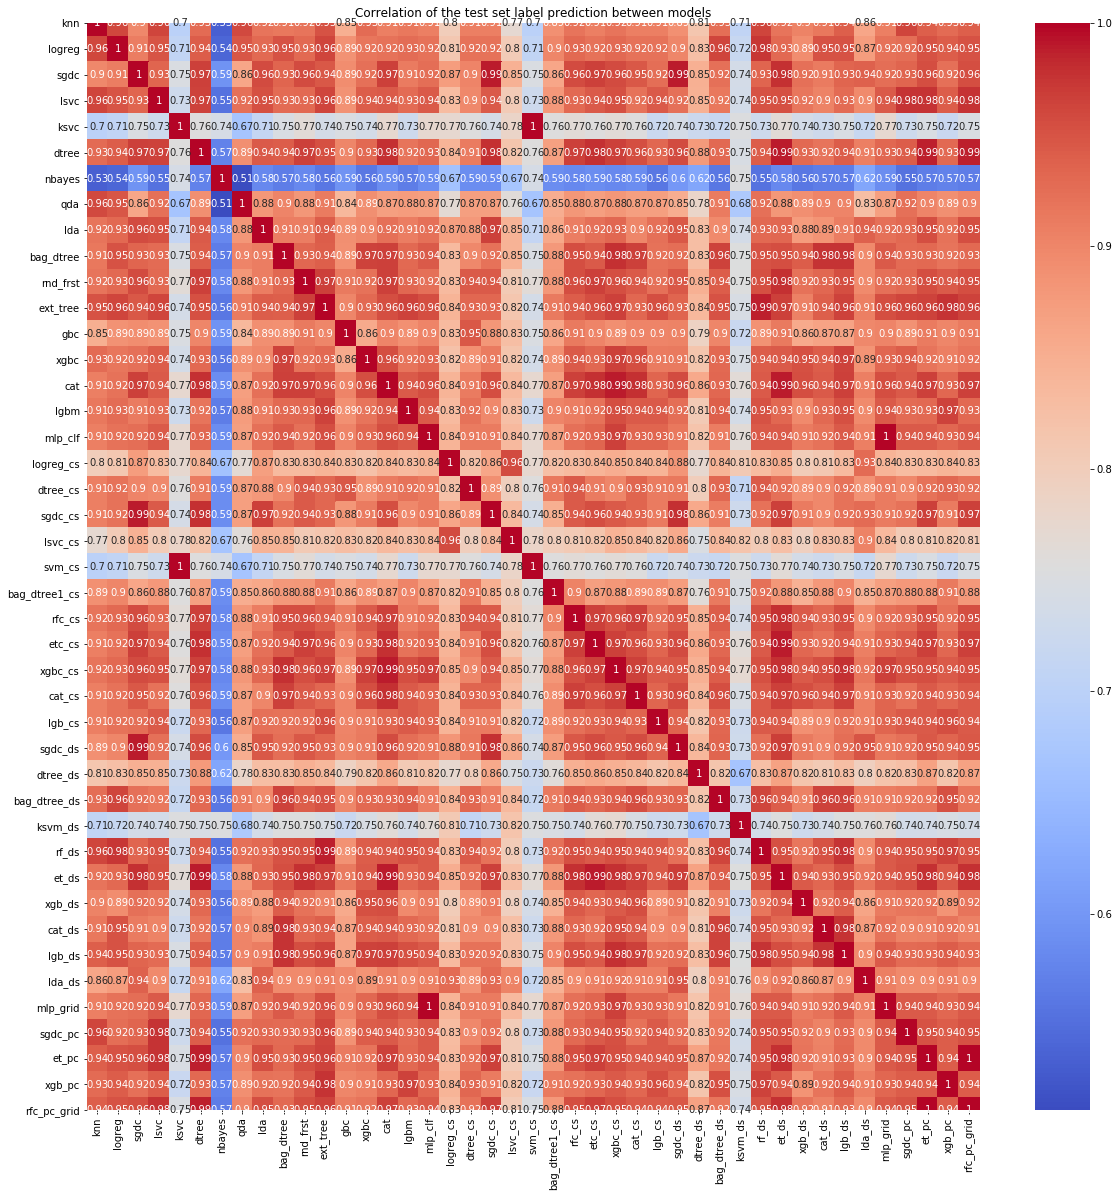

In [248]:
# Plot a heatmap of all correlations for easier visualization
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,20))
g = sns.heatmap(pred.corr(), annot=True, cmap='coolwarm', ax=ax)
g.set_title('Correlation of the test set label prediction between models')

In [251]:
def get_redundant_pairs(data):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = data.columns
    for i in range(0, data.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

In [254]:
def get_top_abs_correlations(data, n=10):
    au_corr = data.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(data)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=True)
    return au_corr[0:n]

In [255]:
print("Least Absolute Correlations")
print(get_top_abs_correlations(pred, 10))

Least Absolute Correlations
nbayes  qda             0.511837
knn     nbayes          0.533484
logreg  nbayes          0.540513
lsvc    nbayes          0.554311
nbayes  rf_ds           0.554311
        sgdc_pc         0.554311
        xgbc            0.561000
        xgb_ds          0.561000
        bag_dtree_ds    0.561088
        ext_tree        0.561088
dtype: float64


In [256]:
classifiers.keys()

dict_keys(['knn', 'logreg', 'sgdc', 'lsvc', 'ksvc', 'dtree', 'nbayes', 'qda', 'lda', 'bag_dtree', 'rnd_frst', 'ext_tree', 'gbc', 'xgbc', 'cat', 'lgbm', 'mlp_clf', 'logreg_cs', 'dtree_cs', 'sgdc_cs', 'lsvc_cs', 'svm_cs', 'bag_dtree1_cs', 'rfc_cs', 'etc_cs', 'xgbc_cs', 'cat_cs', 'lgb_cs', 'sgdc_ds', 'dtree_ds', 'bag_dtree_ds', 'ksvm_ds', 'rf_ds', 'et_ds', 'xgb_ds', 'cat_ds', 'lgb_ds', 'lda_ds', 'mlp_grid', 'sgdc_pc', 'et_pc', 'xgb_pc', 'rfc_pc_grid'])

## Voting

In [259]:
from sklearn.ensemble import VotingClassifier
vclf1 = VotingClassifier(estimators=
                              [('sgd_pc', sgd_pc_grid.best_estimator_), 
                               ('xgbc_cs', xgbc_grid_cs.best_estimator_), 
                               ('logreg_cs', logreg_grid_cs.best_estimator_),
#                                ('cat_cs', cat_grid_cs.best_estimator_),
                               ('lda', lda_grid.best_estimator_)
                              ], )
vclf1_param = {
              'voting' : ['hard','soft'],
             }
vclf1_grid = GridSearchCV(vclf1, vclf1_param,cv=5, return_train_score=True, scoring = f2score )
vclf1_grid.fit(X_train,y_train)
print(f'Best Mean Cross Validation Score is {vclf1_grid.best_score_}')
print(f'Best Params {vclf1_grid.best_params_}')
print(f'Train score is {vclf1_grid.score(X_train,y_train)}')
print(f'Test score is {vclf1_grid.score(X_test,y_test)}')
print(f'Val score is {vclf1_grid.score(X_val,y_val)}')

Best Mean Cross Validation Score is 0.8716810392209619
Best Params {'voting': 'soft'}
Train score is 0.8776978417266186
Test score is 0.803921568627451
Val score is 0.836734693877551


In [260]:
from sklearn.ensemble import VotingClassifier
vclf2 = VotingClassifier(estimators=
                              [('rfc_cs', rfc_grid2_cs.best_estimator_), 
                               ('xgbc_cs', xgbc_grid_cs.best_estimator_), 
                               ('bag_dtree', bag_dtree1_grid.best_estimator_),
                               ('etc_cs', etc_grid2_cs.best_estimator_),
                               ('lgbm', lgbm_grid.best_estimator_)
                              ], )
vclf2_param = {
              'voting' : ['hard','soft'],
             }
vclf2_grid = GridSearchCV(vclf1, vclf1_param,cv=5, return_train_score=True, scoring = f2score )
vclf2_grid.fit(X_train,y_train)
print(f'Best Mean Cross Validation Score is {vclf2_grid.best_score_}')
print(f'Best Params {vclf2_grid.best_params_}')
print(f'Train score is {vclf2_grid.score(X_train,y_train)}')
print(f'Test score is {vclf2_grid.score(X_test,y_test)}')
print(f'Val score is {vclf2_grid.score(X_val,y_val)}')

Best Mean Cross Validation Score is 0.8729296657317999
Best Params {'voting': 'soft'}
Train score is 0.8717579250720461
Test score is 0.803921568627451
Val score is 0.836734693877551


In [265]:
from sklearn.ensemble import VotingClassifier
vclf3 = VotingClassifier(estimators=
                              [('sgdc_ds', sgdc_ds.best_estimator_), 
                               ('et_ds', et_ds2.best_estimator_), 
                               ('rf_ds', rf_ds.best_estimator_)
                              ], )
vclf3_param = {
              'voting' : ['hard','soft'],
             }
vclf3_grid = GridSearchCV(vclf1, vclf1_param,cv=5, return_train_score=True, scoring = f2score )
vclf3_grid.fit(X_train,y_train)
print(f'Best Mean Cross Validation Score is {vclf3_grid.best_score_}')
print(f'Best Params {vclf3_grid.best_params_}')
print(f'Train score is {vclf3_grid.score(X_train,y_train)}')
print(f'Test score is {vclf3_grid.score(X_test,y_test)}')
print(f'Val score is {vclf3_grid.score(X_val,y_val)}')

Best Mean Cross Validation Score is 0.8729296657317999
Best Params {'voting': 'soft'}
Train score is 0.8730158730158731
Test score is 0.803921568627451
Val score is 0.8401639344262295


## Stacking 

In [268]:
from sklearn.ensemble import StackingClassifier

In [280]:
sclf1 = StackingClassifier(estimators=
                              [('etc_cs', etc_grid2_cs.best_estimator_), 
                               ('logreg', logreg_grid.best_estimator_), 
                               ('qda', qda_grid.best_estimator_),
                               ('lgbm', lgbm_grid.best_estimator_),
                               ('mlp_clf', mlp_clf.best_estimator_),
                               ('knn',knn_grid.best_estimator_)
                              ], final_estimator=SGDClassifier())

sclf1_param = {
              'stack_method':['auto', 'predict_proba']
             }
sclf1_grid = GridSearchCV(sclf1, sclf1_param,cv=5, return_train_score=True, scoring = f2score)
sclf1_grid.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=StackingClassifier(cv=None,
                                          estimators=[('etc_cs',
                                                       ExtraTreesClassifier(bootstrap=False,
                                                                            ccp_alpha=0.0,
                                                                            class_weight={0: 1,
                                                                                          1: 10},
                                                                            criterion='gini',
                                                                            max_depth=50,
                                                                            max_features='auto',
                                                                            max_leaf_nodes=None,
                                                                            max_samples=None

In [281]:
print(f'Best Mean Cross Validation Score is {sclf1_grid.best_score_}')
print(f'Best Mean Cross Validation Score is {sclf1_grid.best_params_}')
print(f'Train score is {sclf1_grid.score(X_train,y_train)}')
print(f'Test score is {sclf1_grid.score(X_test,y_test)}')
print(f'Val score is {sclf1_grid.score(X_val,y_val)}')

Best Mean Cross Validation Score is 0.8425559556715158
Best Mean Cross Validation Score is {'stack_method': 'auto'}
Train score is 0.8879184861717613
Test score is 0.6854838709677419
Val score is 0.8436213991769548


In [282]:
sclf2 = StackingClassifier(estimators=
                              [('nbayes', naive_grid.best_estimator_), 
                               ('rf_ds', rf_ds.best_estimator_), 
                               ('xgb_ds', xgb_ds2.best_estimator_),
                               ('ext_tree', etc_grid2.best_estimator_),
                               ('qda', qda_grid.best_estimator_),
                               ('logreg',logreg_grid.best_estimator_)
                              ], final_estimator=SGDClassifier())

sclf2_param = {
              'stack_method':['auto', 'predict_proba']
             }
sclf2_grid = GridSearchCV(sclf2, sclf2_param, cv=5, return_train_score=True, scoring = f2score)
sclf2_grid.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=StackingClassifier(cv=None,
                                          estimators=[('nbayes',
                                                       GaussianNB(priors=None,
                                                                  var_smoothing=0.01)),
                                                      ('rf_ds',
                                                       Pipeline(memory=None,
                                                                steps=[('smote',
                                                                        SMOTE(k_neighbors=5,
                                                                              n_jobs=None,
                                                                              random_state=None,
                                                                              sampling_strategy='auto')),
                                                                       (

In [283]:
print(f'Best Mean Cross Validation Score is {sclf2_grid.best_score_}')
print(f'Best Mean Cross Validation Score is {sclf2_grid.best_params_}')
print(f'Train score is {sclf2_grid.score(X_train,y_train)}')
print(f'Test score is {sclf2_grid.score(X_test,y_test)}')
print(f'Val score is {sclf2_grid.score(X_val,y_val)}')

Best Mean Cross Validation Score is 0.8683197366537858
Best Mean Cross Validation Score is {'stack_method': 'auto'}
Train score is 0.9149855907780979
Test score is 0.803921568627451
Val score is 0.823045267489712


In [288]:
sclf3 = StackingClassifier(estimators=
                              [('lgbm', lgbm_grid.best_estimator_), 
                               ('xgb_ds', xgb_ds2.best_estimator_),
                               ('logreg',logreg_grid.best_estimator_),
                              ], final_estimator=ExtraTreesClassifier(bootstrap= False,criterion='gini', max_depth= 50, 
                                                  max_features= 'auto', min_samples_leaf= 2, min_samples_split= 2, 
                                                  n_estimators= 140, random_state =42, class_weight= {0: 1, 1: 10}))

sclf3_param = {
              'stack_method':['auto', 'predict_proba']
             }
sclf3_grid = GridSearchCV(sclf3, sclf3_param, cv=5, return_train_score=True, scoring = f2score)
sclf3_grid.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=StackingClassifier(cv=None,
                                          estimators=[('lgbm',
                                                       LGBMClassifier(boosting_type='gbdt',
                                                                      class_weight=None,
                                                                      colsample_bytree=1,
                                                                      importance_type='split',
                                                                      learning_rate=0.4,
                                                                      max_depth=10,
                                                                      min_child_samples=20,
                                                                      min_child_weight=0.001,
                                                                      min_split_gain=0.3,
                                   

In [289]:
print(f'Best Mean Cross Validation Score is {sclf3_grid.best_score_}')
print(f'Best Mean Cross Validation Score is {sclf3_grid.best_params_}')
print(f'Train score is {sclf3_grid.score(X_train,y_train)}')
print(f'Test score is {sclf3_grid.score(X_test,y_test)}')
print(f'Val score is {sclf3_grid.score(X_val,y_val)}')

Best Mean Cross Validation Score is 0.8716415592483304
Best Mean Cross Validation Score is {'stack_method': 'auto'}
Train score is 0.8913043478260869
Test score is 0.767716535433071
Val score is 0.8536585365853657


In [279]:
sclf4 = StackingClassifier(estimators=
                              [('nbayes', naive_grid.best_estimator_), 
                               ('xgb_ds', xgb_ds2.best_estimator_),
                               ('logreg',logreg_grid.best_estimator_),
                               ('sgdc_cs',sgdc_grid_cs)
                              ], final_estimator=ExtraTreesClassifier(bootstrap= False,criterion='gini', max_depth= 50, 
                                                  max_features= 'auto', min_samples_leaf= 2, min_samples_split= 2, 
                                                  n_estimators= 140, random_state =42, class_weight= {0: 1, 1: 10}))

sclf4_param = {
              'stack_method':['auto']
             }
sclf4_grid = GridSearchCV(sclf4, sclf4_param, cv=5, return_train_score=True, scoring = f2score)
sclf4_grid.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=StackingClassifier(cv=None,
                                          estimators=[('nbayes',
                                                       GaussianNB(priors=None,
                                                                  var_smoothing=0.01)),
                                                      ('xgb_ds',
                                                       Pipeline(memory=None,
                                                                steps=[('smote',
                                                                        BorderlineSMOTE(k_neighbors=4,
                                                                                        kind='borderline-1',
                                                                                        m_neighbors=10,
                                                                                        n_jobs=None,
                                         

In [284]:
print(f'Best Mean Cross Validation Score is {sclf4_grid.best_score_}')
print(f'Best Mean Cross Validation Score is {sclf4_grid.best_params_}')
print(f'Train score is {sclf4_grid.score(X_train,y_train)}')
print(f'Test score is {sclf4_grid.score(X_test,y_test)}')
print(f'Val score is {sclf4_grid.score(X_val,y_val)}')

Best Mean Cross Validation Score is 0.8645326613731366
Best Mean Cross Validation Score is {'stack_method': 'auto'}
Train score is 0.8815028901734104
Test score is 0.813953488372093
Val score is 0.8704453441295547


In [290]:
sclf5 = StackingClassifier(estimators=
                              [('lgbm', lgbm_grid.best_estimator_), 
                               ('xgb_ds', xgb_ds2.best_estimator_),
                               ('logreg',logreg_grid.best_estimator_),
                               ('sgdc_cs',sgdc_grid_cs)
                              ], final_estimator=ExtraTreesClassifier(bootstrap= False,criterion='gini', max_depth= 50, 
                                                  max_features= 'auto', min_samples_leaf= 2, min_samples_split= 2, 
                                                  n_estimators= 140, random_state =42, class_weight= {0: 1, 1: 10}))

sclf5_param = {
              'stack_method':['auto']
             }
sclf5_grid = GridSearchCV(sclf5, sclf5_param, cv=5, return_train_score=True, scoring = f2score)
sclf5_grid.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=StackingClassifier(cv=None,
                                          estimators=[('lgbm',
                                                       LGBMClassifier(boosting_type='gbdt',
                                                                      class_weight=None,
                                                                      colsample_bytree=1,
                                                                      importance_type='split',
                                                                      learning_rate=0.4,
                                                                      max_depth=10,
                                                                      min_child_samples=20,
                                                                      min_child_weight=0.001,
                                                                      min_split_gain=0.3,
                                   

In [291]:
print(f'Best Mean Cross Validation Score is {sclf5_grid.best_score_}')
print(f'Best Mean Cross Validation Score is {sclf5_grid.best_params_}')
print(f'Train score is {sclf5_grid.score(X_train,y_train)}')
print(f'Test score is {sclf5_grid.score(X_test,y_test)}')
print(f'Val score is {sclf5_grid.score(X_val,y_val)}')

Best Mean Cross Validation Score is 0.8597372492853157
Best Mean Cross Validation Score is {'stack_method': 'auto'}
Train score is 0.8840579710144927
Test score is 0.767716535433071
Val score is 0.8536585365853657


In [295]:
sclf6 = StackingClassifier(estimators=
                              [('xgb_ds', xgb_ds2.best_estimator_),            
                               ('sgdc_cs',sgdc_grid_cs),
                               ('etc_cs', etc_grid2_cs.best_estimator_)
                              ], final_estimator=SVC(C= 4, degree = 2, kernel = 'rbf', class_weight= {0: 1, 1: 1}))

sclf6_param = {
              'stack_method':['auto']
             }
sclf6_grid = GridSearchCV(sclf6, sclf6_param, cv=5, return_train_score=True, scoring = f2score)
sclf6_grid.fit(X_train,y_train)


GridSearchCV(cv=5, error_score=nan,
             estimator=StackingClassifier(cv=None,
                                          estimators=[('xgb_ds',
                                                       Pipeline(memory=None,
                                                                steps=[('smote',
                                                                        BorderlineSMOTE(k_neighbors=4,
                                                                                        kind='borderline-1',
                                                                                        m_neighbors=10,
                                                                                        n_jobs=None,
                                                                                        random_state=None,
                                                                                        sampling_strategy='auto')),
                                                  

In [296]:
print(f'Best Mean Cross Validation Score is {sclf6_grid.best_score_}')
print(f'Best Mean Cross Validation Score is {sclf6_grid.best_params_}')
print(f'Train score is {sclf6_grid.score(X_train,y_train)}')
print(f'Test score is {sclf6_grid.score(X_test,y_test)}')
print(f'Val score is {sclf6_grid.score(X_val,y_val)}')

Best Mean Cross Validation Score is 0.8622411612399097
Best Mean Cross Validation Score is {'stack_method': 'auto'}
Train score is 0.8780841799709724
Test score is 0.803921568627451
Val score is 0.8571428571428571


# Submission CSV

In [ ]:
test_data_labels = sclf6_grid.predict(test2)
test_data_labels = pd.DataFrame(test_data_labels)
test_data_labels["Id"] = test3["Id"]
test_data_labels.rename(columns = {0:"Target"}, inplace =True)
test_data_labels.to_csv('solution_base.csv', index =False)